In [314]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import utils as utils
import missingno as msno

df = pd.read_csv('../data/raw/train.csv', sep=';', low_memory=False)
df.info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 100 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev_Mean          79707 non-null  float64
 1   mou_Mean          79707 non-null  float64
 2   totmrc_Mean       79707 non-null  float64
 3   da_Mean           79707 non-null  float64
 4   ovrmou_Mean       79707 non-null  float64
 5   ovrrev_Mean       79707 non-null  float64
 6   vceovr_Mean       79707 non-null  float64
 7   datovr_Mean       79707 non-null  float64
 8   roam_Mean         79707 non-null  float64
 9   change_mou        79282 non-null  float64
 10  change_rev        79282 non-null  float64
 11  drop_vce_Mean     80000 non-null  float64
 12  drop_dat_Mean     80000 non-null  float64
 13  blck_vce_Mean     80000 non-null  float64
 14  blck_dat_Mean     80000 non-null  float64
 15

Las variables categóricas demográficas (las que sus nulos son un 100% explicados por la ausencia de InfoBase) son extraídas de InfoBase. Por lo tanto, vamos a generar una categoría extra para los casos en los que se desconoce, y a generar una única columna de flags para los cuales están presentes o no estas variables en el inicio.

In [315]:
# Ahora vamos a analizar anomalías, como valores negativos en variables que no tienen sentido, ya que hablan de cantidades que tienen que ser positivas (minutos, llamadas...)

columnas_numericas = df.select_dtypes(include='number').columns.tolist()

columnas_a_excluir = ['change_rev', 'change_mou'] #pueden ser negativas porque son porcentajes de cambio

columnas_finales_a_verificar = [
    col for col in columnas_numericas if col not in columnas_a_excluir
]

resumen, df_negativos = utils.auditar_valores_negativos(df, columnas_finales_a_verificar)

if not df_negativos.empty:
    print("\n--- Procediendo con la limpieza de filas anómalas ---")
    
    # Obtenemos los índices de las filas problemáticas
    indices_a_eliminar = df_negativos.index
    
    # Eliminamos esas filas del DataFrame original
    df_limpio = df.drop(indices_a_eliminar)
    
    print(f"Tamaño original del dataset: {len(df)}")
    print(f"Tamaño del dataset tras la limpieza: {len(df_limpio)}")
    print(f"Filas eliminadas: {len(df) - len(df_limpio)}")
else:
    print("\nEl dataset ya está limpio de valores negativos anómalos.")
    df_limpio = df.copy() # Creamos una copia para seguir trabajando


--- Auditoría de Valores Negativos ---
Se encontraron valores negativos en las siguientes columnas:
- rev_Mean: 5 valores negativos
- totmrc_Mean: 21 valores negativos
- avg6rev: 3 valores negativos
- eqpdays: 113 valores negativos

--- Mostrando filas con al menos un valor negativo detectado ---
       rev_Mean  totmrc_Mean  avg6rev  eqpdays
274     95.3500      84.9900    205.0     -3.0
523     -6.1675      -6.1675      NaN    203.0
910     50.2375      59.9900     50.0     -3.0
1081    95.4875      56.4900     73.0     -2.0
1223     8.8200      -0.2400     29.0    318.0
...         ...          ...      ...      ...
77699    3.5625      -1.4225     27.0    363.0
78248   85.4575      84.9900     86.0     -3.0
78648  197.6600      84.9900    152.0     -2.0
79386   48.9825      69.9900     75.0     -4.0
79708   75.8150      51.3225     66.0     -3.0

[139 rows x 4 columns]

--- Procediendo con la limpieza de filas anómalas ---
Tamaño original del dataset: 80000
Tamaño del dataset tras 

Se han eliminado 161 columnas en total de valores que no tiene sentido que sean negativos. Esto sólo es un 0.161% de los datos que tenemos disponibles, así que podemos seguir trabajando con el dataframe limpio de estos casos.

<Figure size 2580x2580 with 0 Axes>

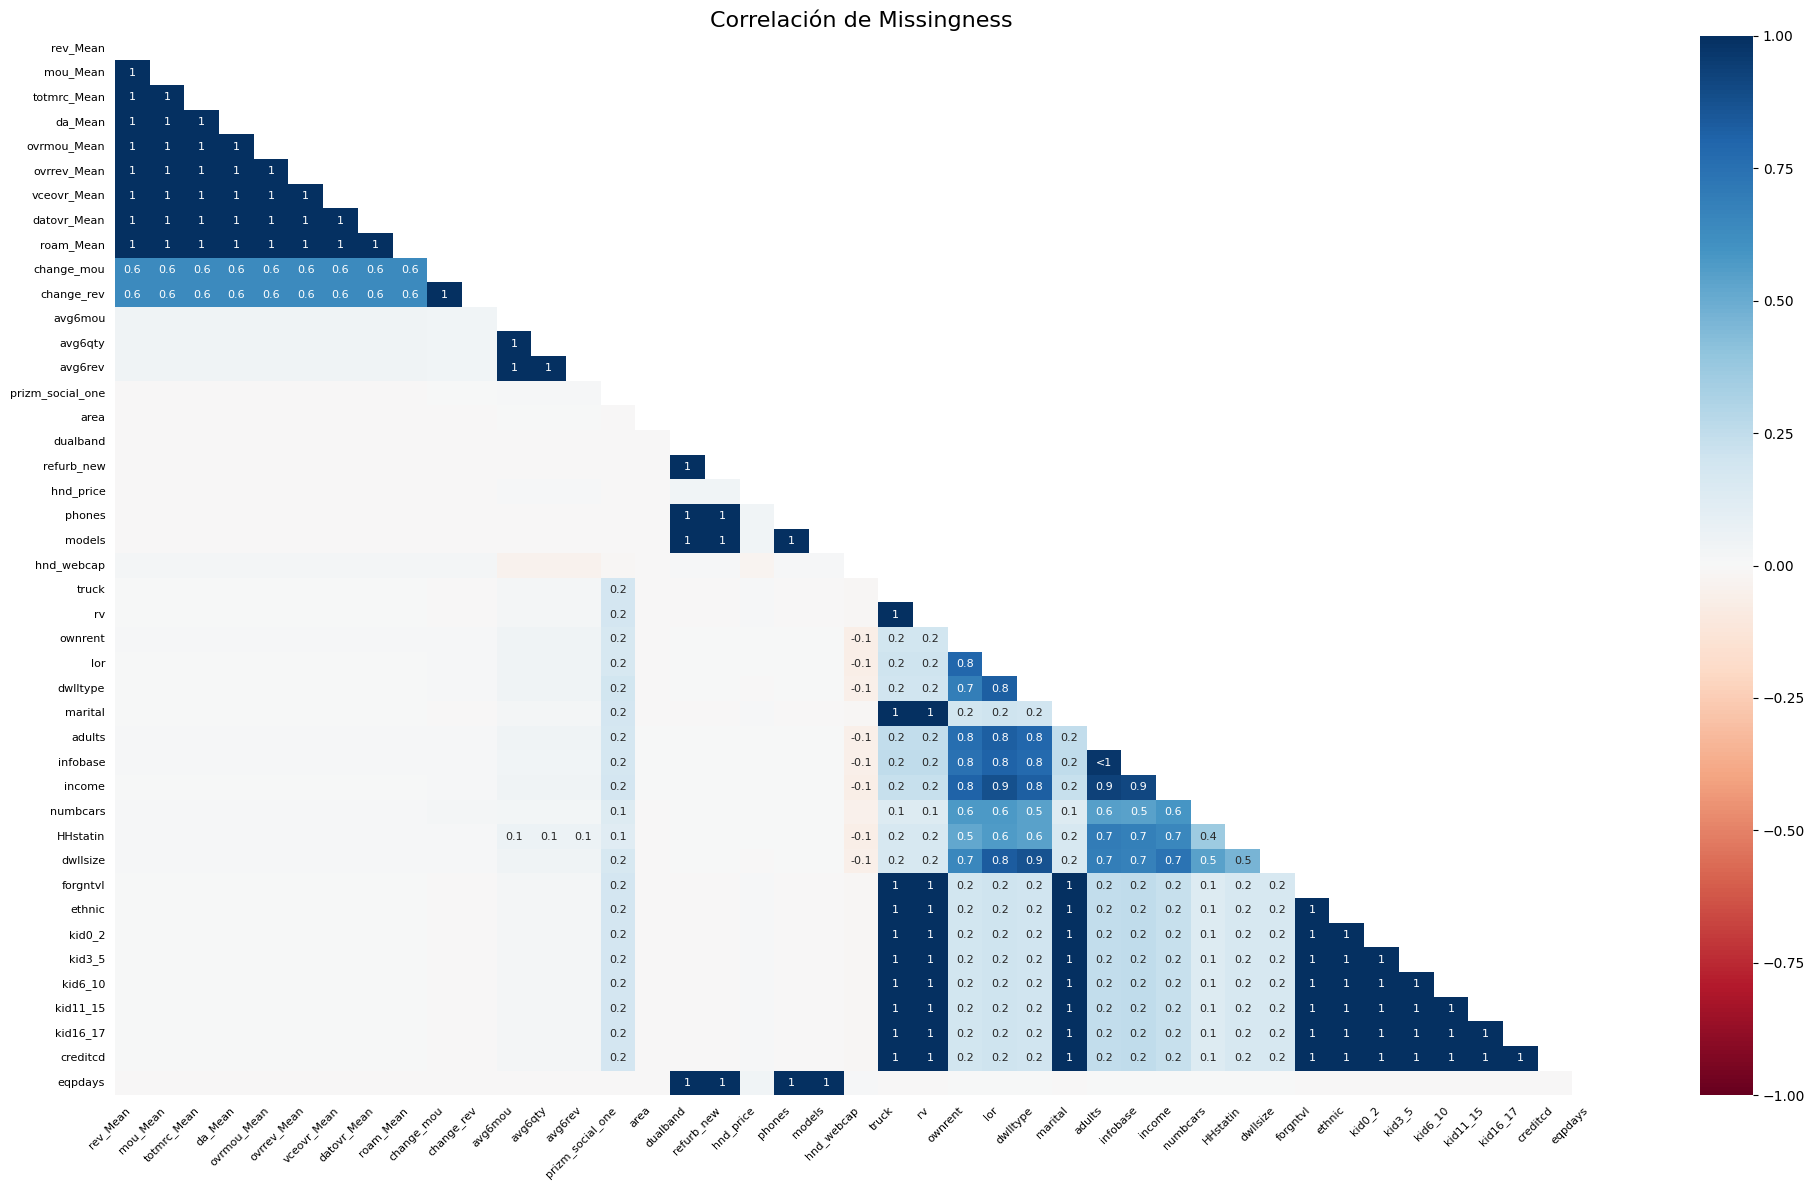

In [316]:
null_info = utils.calcular_nulos(df_limpio)

columns_with_nans = null_info[null_info['Nulos'] > 0].index.tolist()

null_flags_df_subset = df[columns_with_nans].isnull()

missing_patterns_subset = null_flags_df_subset.groupby(null_flags_df_subset.columns.tolist()).size().reset_index(name='count')

print("\n")
    
num_cols = len(columns_with_nans)
recommended_width = max(10, num_cols * 0.6)
recommended_height = max(9, num_cols * 0.6) 

plt.figure(figsize=(recommended_width, recommended_height))
ax = msno.heatmap(df[columns_with_nans], fontsize=10) 

plt.xticks(rotation=45, ha='right', fontsize=8) 
plt.yticks(rotation=0, fontsize=8) 

plt.title('Correlación de Missingness', fontsize=16)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()
    

Hay una fila que tiene los campos `dualband`, `refurb_new`, `phones`, `models` y `eqpdays` a null, así que la vamos a eliminar. También lo haremos con las líneas con menos nulos como `area`.

In [317]:
df_limpio = df[~df['dualband'].isnull()].copy()

df_limpio = df_limpio[~df_limpio['area'].isnull()].copy()
len(df_limpio)

79969

In [318]:
utils.crear_flag_nulos(df_limpio, 'infobase', 'infobase_null')

# 2. Agrupamos y contamos los nulos (usando el código corregido y a prueba de futuro)
resumen_nulos_por_grupo = df_limpio.groupby('infobase_null').apply(lambda x: x.isnull().sum(), include_groups=False)
resumen_final = resumen_nulos_por_grupo.transpose()

# 3. Renombramos las columnas booleanas para mayor claridad
resumen_final.rename(columns={True: 'nulos_si_infobase_es_nulo', False: 'nulos_si_infobase_es_ok'}, inplace=True)

# 4. Calculamos el total de nulos para cada variable
resumen_final['total_nulos'] = resumen_final['nulos_si_infobase_es_nulo'] + resumen_final['nulos_si_infobase_es_ok']

# 5. Calculamos el porcentaje de nulos que ocurren cuando infobase también es nulo
#    Este es el indicador clave de dependencia
resumen_final['%_nulos_explicado_por_infobase'] = \
    (resumen_final['nulos_si_infobase_es_nulo'] / resumen_final['total_nulos']) * 100

# 6. Ordenamos la tabla por este nuevo porcentaje para ver los resultados más claros
resumen_final.sort_values(by='%_nulos_explicado_por_infobase', ascending=False, inplace=True)

# 7. Filtramos y formateamos la salida final para una vista limpia
#    Mostramos solo las variables que tienen nulos
resumen_filtrado = resumen_final[resumen_final['total_nulos'] > 0]

# Seleccionamos y reordenamos las columnas que queremos ver
columnas_a_mostrar = ['total_nulos', 'nulos_si_infobase_es_nulo', '%_nulos_explicado_por_infobase']
vista_final = resumen_filtrado[columnas_a_mostrar]

# Formateamos el porcentaje para que se vea bien
vista_final['%_nulos_explicado_por_infobase'] = vista_final['%_nulos_explicado_por_infobase'].map('{:.2f}%'.format)


print("--- Dependencia de Nulos en la variable 'infobase' ---")
print(vista_final)


Número de 1s en la nueva columna flag: infobase_null
1    17688
Name: count, dtype: int64

--- Dependencia de Nulos en la variable 'infobase' ---
infobase_null     total_nulos  nulos_si_infobase_es_nulo  \
kid6_10                  1409                       1409   
kid3_5                   1409                       1409   
kid0_2                   1409                       1409   
rv                       1409                       1409   
truck                    1409                       1409   
forgntvl                 1409                       1409   
ethnic                   1409                       1409   
infobase                17688                      17688   
marital                  1409                       1409   
creditcd                 1409                       1409   
kid11_15                 1409                       1409   
kid16_17                 1409                       1409   
adults                  18441                      17688   
income        

/tmp/ipykernel_98015/1427101156.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vista_final['%_nulos_explicado_por_infobase'] = vista_final['%_nulos_explicado_por_infobase'].map('{:.2f}%'.format)


--- Análisis de Churn para la Variable Categórica: 'infobase_null' ---
               Tasa de Churn  Total Clientes
infobase_null                               
1                   0.520353           17688
0                   0.488544           62281




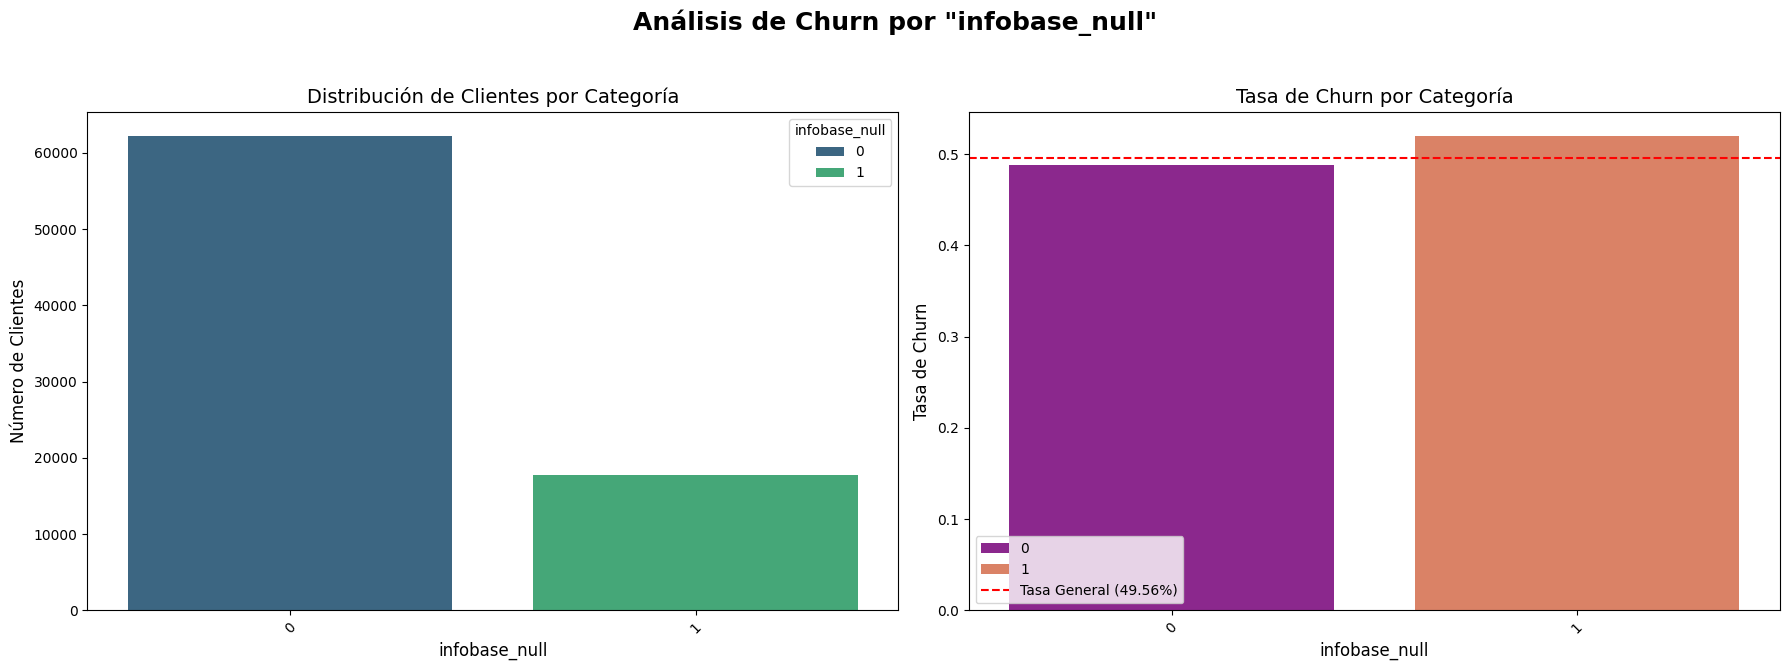

                  Nulos  Porcentaje
rev_Mean            293    0.366392
mou_Mean            293    0.366392
totmrc_Mean         293    0.366392
da_Mean             293    0.366392
ovrmou_Mean         293    0.366392
ovrrev_Mean         293    0.366392
vceovr_Mean         293    0.366392
datovr_Mean         293    0.366392
roam_Mean           293    0.366392
change_mou          718    0.897848
change_rev          718    0.897848
avg6mou            2269    2.837349
avg6qty            2269    2.837349
avg6rev            2269    2.837349
prizm_social_one   5896    7.372857
hnd_price           695    0.869087
hnd_webcap         8160   10.203954
ownrent           26990   33.750578
lor               24156   30.206705
dwlltype          25547   31.946129
adults            18441   23.060186
income            20362   25.462367
numbcars          39497   49.390389
HHstatin          30382   37.992222
dwllsize          30671   38.353612


In [319]:
cols_depend_infobase = ['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'rv', 'truck', 'forgntvl', 'ethnic', 'infobase', 'marital', 'creditcd']

utils.analizar_churn_categorica(df_limpio, 'infobase_null')

for col in cols_depend_infobase:
    if col in df_limpio.columns and df_limpio[col].isnull().any():

        df_limpio[col] = df_limpio[col].fillna('UNKN')

df_nulos = utils.calcular_nulos(df_limpio)

print(df_nulos[df_nulos['Nulos']>0])

Hay varios grupos en los que varias columnas son nulas a la vez. Vamos a analizar una a una si su presencia o no está asociada al `churn`.

### 1. Variables asociadas a servicios específicos

Primero generamos una columna binaria que nos especifica si ese registro tenía estas variables a null (1) o no (0).

In [320]:
cols_services_null = ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean']

# Sabemos que con que una sea nula, el resto también lo son.
utils.crear_flag_nulos(df_limpio, 'rev_Mean', 'services_null')

Número de 1s en la nueva columna flag: services_null
1    293
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,churn,infobase_null,services_null
0,137.4925,784.00,50.0000,3.9600,272.50,81.7500,81.7500,0.0,1.7825,-704.00,...,U,U,U,U,Y,601.0,1039302,1,0,0
1,59.0650,1702.25,59.9900,0.0000,30.25,9.0750,9.0750,0.0,0.0000,264.75,...,U,U,U,U,N,156.0,1051213,0,1,0
2,44.4700,185.25,30.0000,2.9700,28.75,11.5000,11.5000,0.0,0.0000,-70.25,...,U,Y,U,U,Y,1009.0,1006409,0,0,0
3,28.7450,10.75,39.9900,0.0000,0.00,0.0000,0.0000,0.0,0.0000,-3.75,...,U,Y,Y,U,Y,334.0,1057172,0,0,0
4,109.1925,1757.50,82.6925,0.0000,113.75,45.5000,45.5000,0.0,0.0000,84.50,...,U,U,U,U,N,223.0,1089300,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,150.2850,1867.50,87.4900,3.2175,270.00,67.5000,67.5000,0.0,0.5775,-781.50,...,U,U,U,U,N,249.0,1086168,0,1,0
79996,108.9300,1473.75,109.9900,4.7025,0.00,0.0000,0.0000,0.0,0.0000,463.25,...,U,U,U,U,Y,284.0,1035166,1,0,0
79997,142.4725,773.25,49.9900,1.4850,147.50,51.6250,51.6250,0.0,0.0000,127.75,...,U,U,U,U,N,63.0,1028247,0,1,0
79998,19.9900,14.00,19.9900,0.0000,0.00,0.0000,0.0000,0.0,0.0000,-14.00,...,U,U,U,U,Y,671.0,1032754,0,0,0


--- Análisis de Churn para la Variable Categórica: 'services_null' ---
               Tasa de Churn  Total Clientes
services_null                               
1                   0.689420             293
0                   0.494867           79676




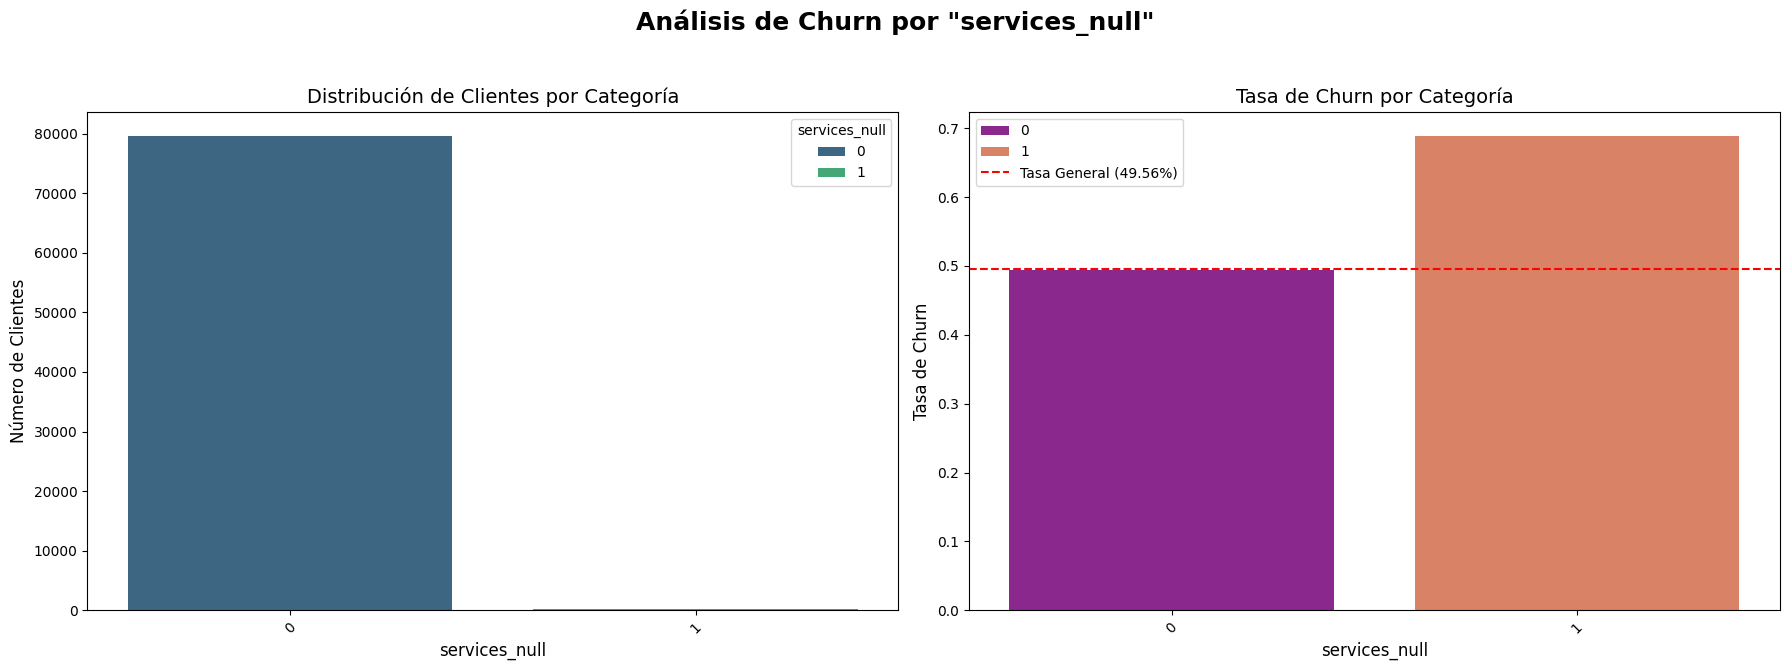

In [321]:
# Ahora observamos si esta variable está asociada al churn
utils.analizar_churn_categorica(df_limpio, 'services_null')

Observamos que la gente que tenía este valor implementado (los que services_null = 0) tienen un abandono acorde con la media, mientras que los que no lo tienen implementado, lo tienen más alto. Esto puede ser debido a que las variables que son nulas a la vez, corresponden a gente que no ha usado servicios extra (roaming, exceso de uso de servicios de voz, de datos, etc). Esto puede indicar que usan poco el servicio, y realmente de manera eventual, decidan darse de baja.

Ahora nos gustaría analizar cómo afectan estas variables a aquellos valores no nulos, para saber cuáles son descartables y cuáles no.

/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(
/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(
/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

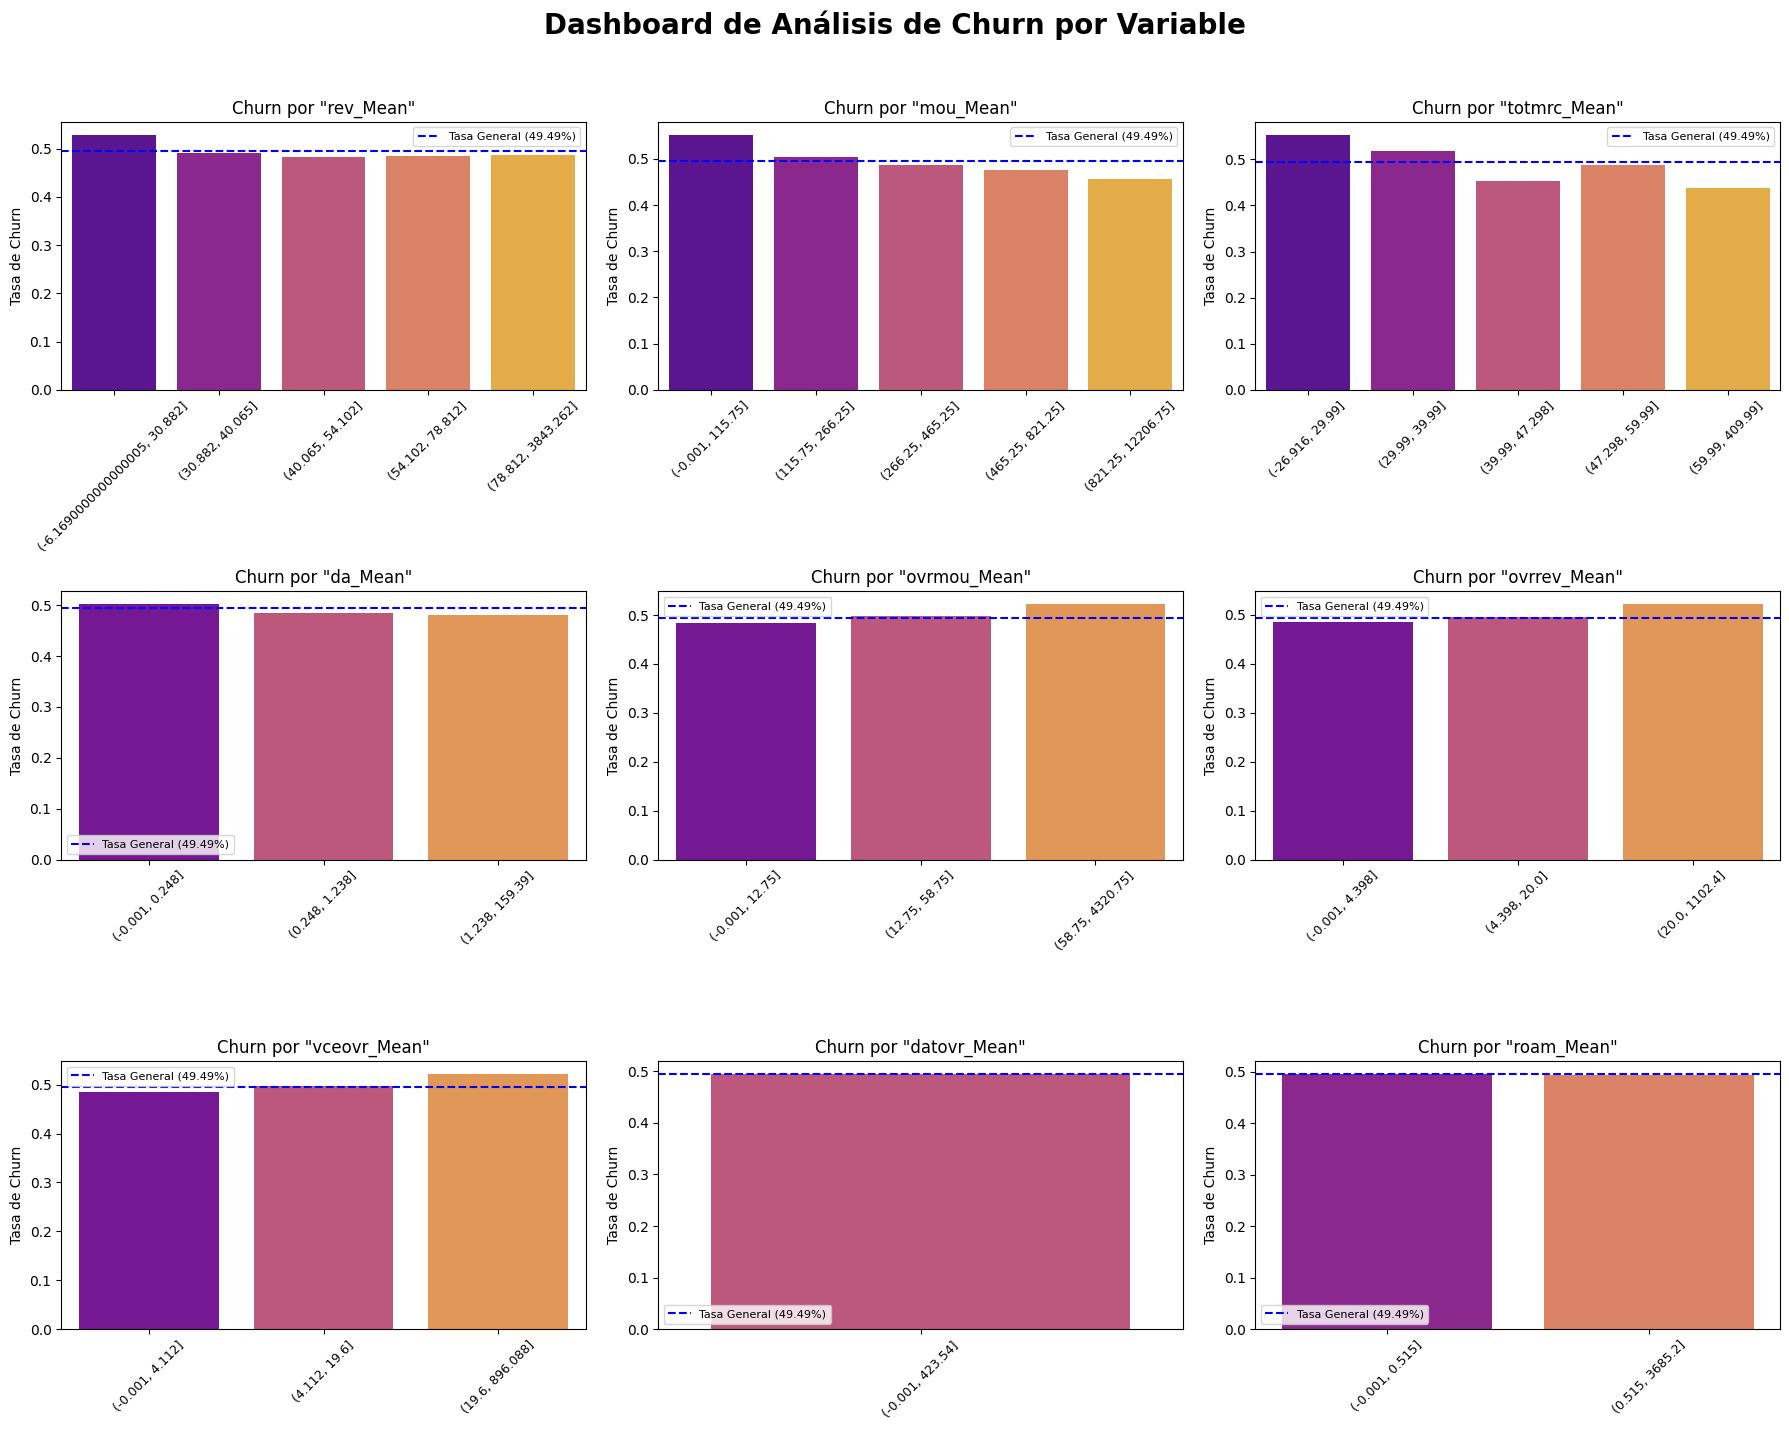

In [322]:
# Obtenemos los usuarios donde están rellenadas estas variables
df_services = df_limpio[df_limpio['services_null'] == 0]

n_cols = len(cols_services_null)
n_layout_cols = 3  # Gráficos por fila (puedes cambiarlo a 2, 3, o 4)
n_layout_rows = (n_cols + n_layout_cols - 1) // n_layout_cols # Cálculo automático de filas

# 3. Crea la figura y los subplots
fig, axes = plt.subplots(n_layout_rows, n_layout_cols, figsize=(n_layout_cols * 6, n_layout_rows * 5))
fig.suptitle('Dashboard de Análisis de Churn por Variable', fontsize=20, weight='bold')

# 'axes' es una matriz de subplots, la aplanamos para iterar fácilmente
axes = axes.flatten()

# 4. Itera sobre las columnas y dibuja cada gráfico en su subplot correspondiente
for i, columna in enumerate(cols_services_null):
    ax = axes[i]
    if is_numeric_dtype(df_services[columna]):
        utils.plot_tasa_churn_numerica(df_services, columna, ax)
    else:
        utils.plot_tasa_churn_categorica(df_services, columna, ax)

for i in range(n_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajustar para el título principal
plt.show()

En las cuatro primeras variables, `rev_Mean`, `mou_Mean`, `totmrc_Mean` y `da_Mean` observamos más tendencia de los usuarios a permanecer según aumentan los valores: estas variables están asociadas a lo que se les cobra, a los minutos de uso y a las llamadas asistidas. Los usuarios que menos pagan tienen más tendencia a irse, dándonos una señal de que posiblemente las tarifas bajas no sean competitivas con el mercado, ya que les podría seguir pareciendo lo suficientemente altas como para irse. Sin embargo, esto no sucede según aumenta el precio, ya que posiblemente en comparación con el uso que se le da, las tarifas sí que ofrecen una buena oferta. Esto quiere decir que hay que poner foco en aquellas personas con tarifas más bajas.

En las variables `ovrmou_Mean`, `ovrrev_Mean` y `vceovr_Mean` vemos una tendencia contraria: cuanto más se les carga por estos servicios, más probabilidad de irse. Al final tiene sentido, ya que son cargos extra que se añaden a la tarifa, y eso puede hacer que el usuario esté disconforme y prefiera irse a otro lado. Posiblemente requiera un aumento de tarifa o una mejora del servicio, incluyendo otro tipo de servicios extra o aumentando la cantidad de minutos utilizar, por ejemplo.

Las variables `datover_Mean` y `roam_Mean` no suponen un indicador del churn, así que podríamos prescindir de ellas. De hecho, en la de datos, casi todos los usuarios están en valores alrededor de 0, por eso los outliers que están, que llegan al máximo, son representados también en la misma barra.

Como los nulos de estas variables son pocos, vamos a asumir que se refieren a nada de uso (imputación por 0), ya que sólo estaríamos modificando el primer bin de las gráficas 0.357%.

In [323]:
df_limpio[cols_services_null] = df_limpio[cols_services_null].fillna(0)

null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
change_mou          718    0.897848
change_rev          718    0.897848
avg6mou            2269    2.837349
avg6qty            2269    2.837349
avg6rev            2269    2.837349
prizm_social_one   5896    7.372857
hnd_price           695    0.869087
hnd_webcap         8160   10.203954
ownrent           26990   33.750578
lor               24156   30.206705
dwlltype          25547   31.946129
adults            18441   23.060186
income            20362   25.462367
numbcars          39497   49.390389
HHstatin          30382   37.992222
dwllsize          30671   38.353612


### 2. Variables categóricas

### 2A. Variable de estado civil

--- Análisis de Churn para la Variable Categórica: 'marital' ---
         Tasa de Churn  Total Clientes
marital                               
U             0.513971           29848
B             0.496214            5679
A             0.491334            4154
M             0.488028           24724
S             0.473684           14155
UNKN          0.468417            1409




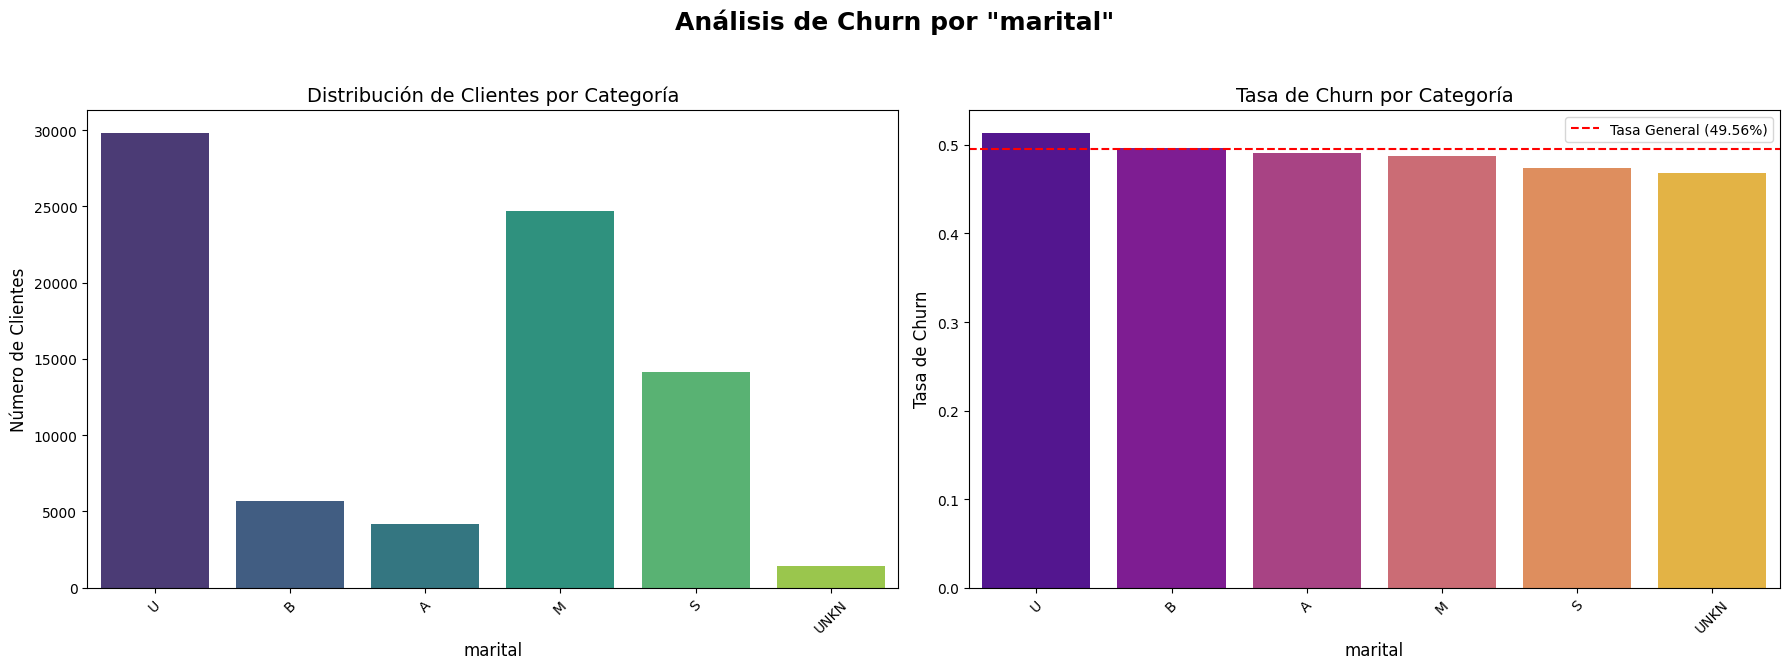

In [324]:
utils.analizar_churn_categorica(df_limpio, 'marital')

### 2B. Variable tarjeta

--- Análisis de Churn para la Variable Categórica: 'creditcd' ---
          Tasa de Churn  Total Clientes
creditcd                               
N              0.509387           24822
Y              0.489914           53738
UNKN           0.468417            1409




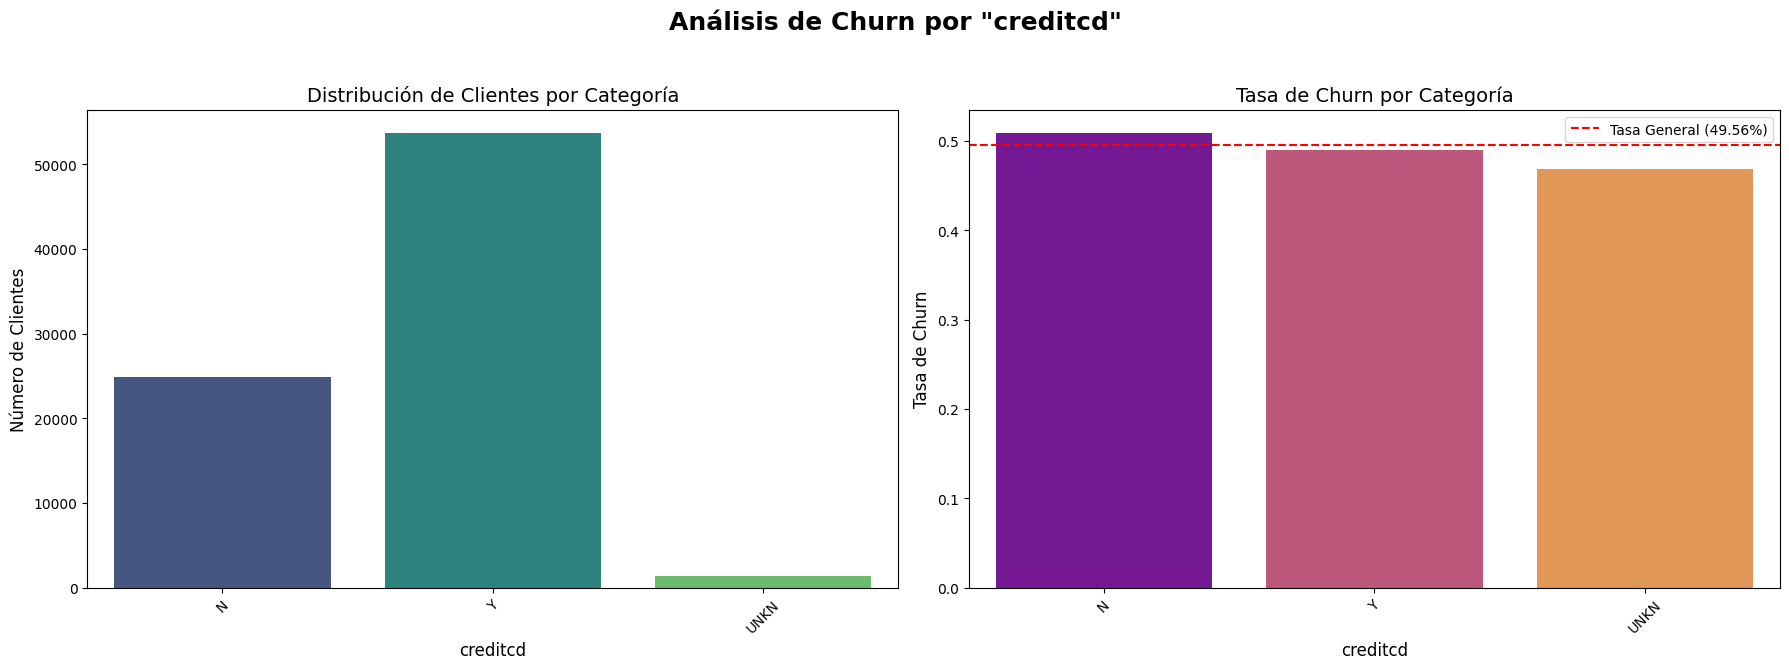

In [325]:
utils.analizar_churn_categorica(df_limpio, 'creditcd')

### 2C. Variable viaje al extranjero

--- Análisis de Churn para la Variable Categórica: 'forgntvl' ---
          Tasa de Churn  Total Clientes
forgntvl                               
0.0            0.496962           74060
1.0            0.481333            4500
UNKN           0.468417            1409




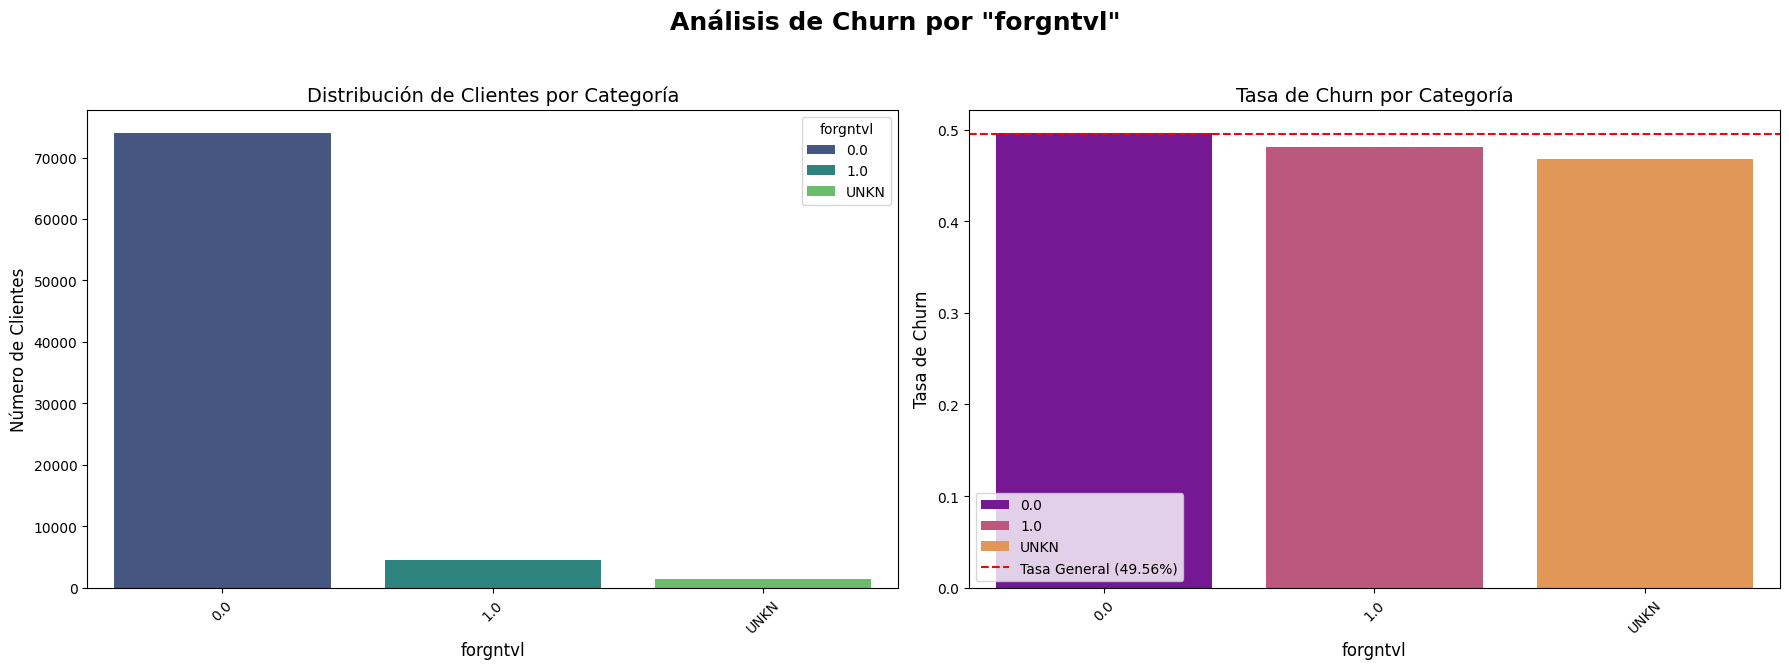

In [326]:
utils.analizar_churn_categorica(df_limpio, 'forgntvl')

### 2D. Variable etnia

--- Análisis de Churn para la Variable Categórica: 'ethnic' ---
        Tasa de Churn  Total Clientes
ethnic                               
O            0.580781            3330
B            0.565647            1112
M            0.551402             107
D            0.530410             707
R            0.528211             833
J            0.517135            2276
H            0.507410           10863
I            0.504590            3050
U            0.500628            8761
F            0.497639            1694
G            0.492070            4792
S            0.491231           10264
N            0.489509           26594
UNKN         0.468417            1409
Z            0.405168            3522
P            0.377834             397
X            0.333333              63
C            0.312821             195




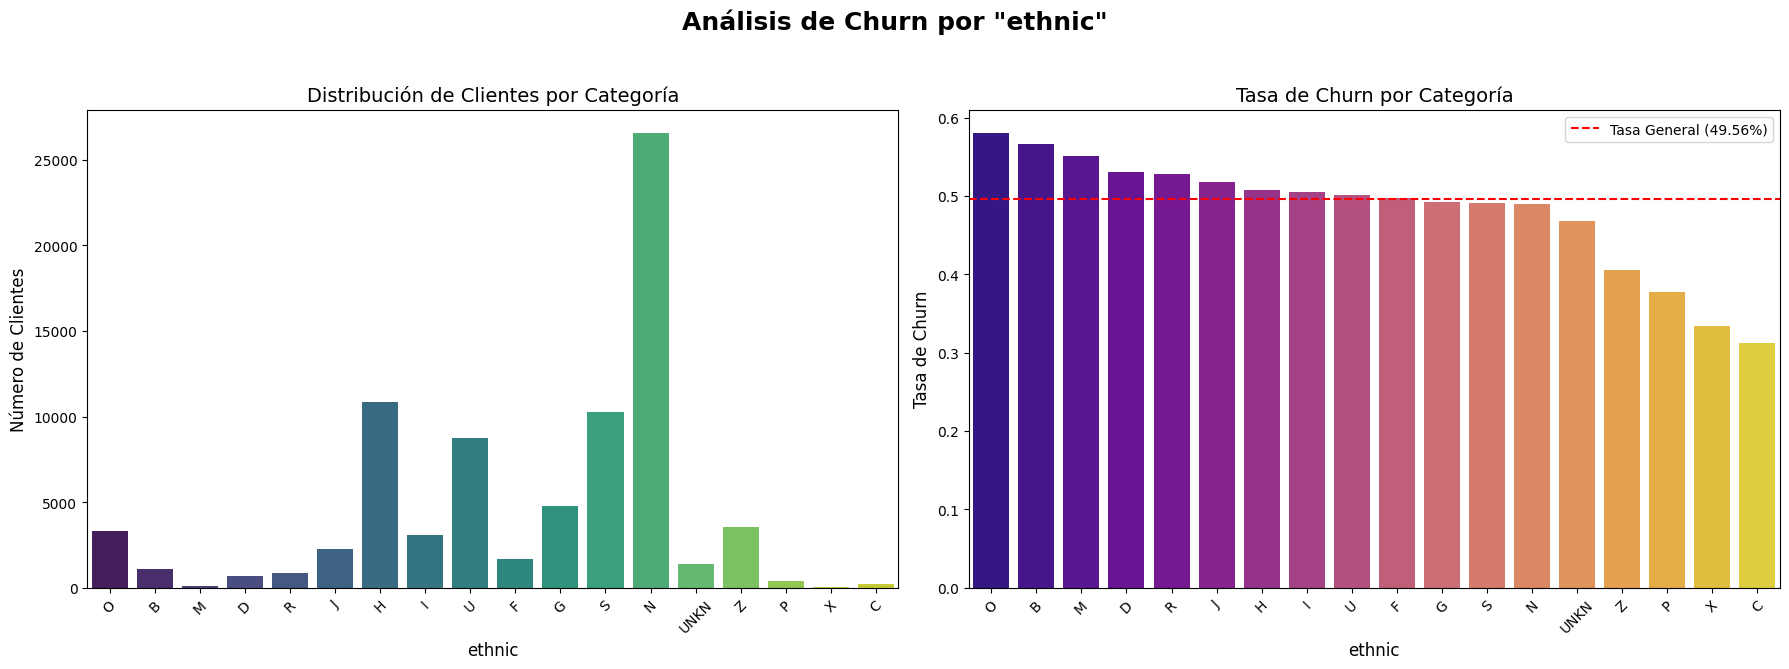

In [327]:
utils.analizar_churn_categorica(df_limpio, 'ethnic')

In [328]:
null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
change_mou          718    0.897848
change_rev          718    0.897848
avg6mou            2269    2.837349
avg6qty            2269    2.837349
avg6rev            2269    2.837349
prizm_social_one   5896    7.372857
hnd_price           695    0.869087
hnd_webcap         8160   10.203954
ownrent           26990   33.750578
lor               24156   30.206705
dwlltype          25547   31.946129
adults            18441   23.060186
income            20362   25.462367
numbcars          39497   49.390389
HHstatin          30382   37.992222
dwllsize          30671   38.353612


### 3. Cambios respecto a los tres meses anteriores

Número de 1s en la nueva columna flag: change_null
1    718
Name: count, dtype: int64

--- Análisis de Churn para la Variable Categórica: 'change_null' ---
             Tasa de Churn  Total Clientes
change_null                               
1                 0.760446             718
0                 0.493180           79251




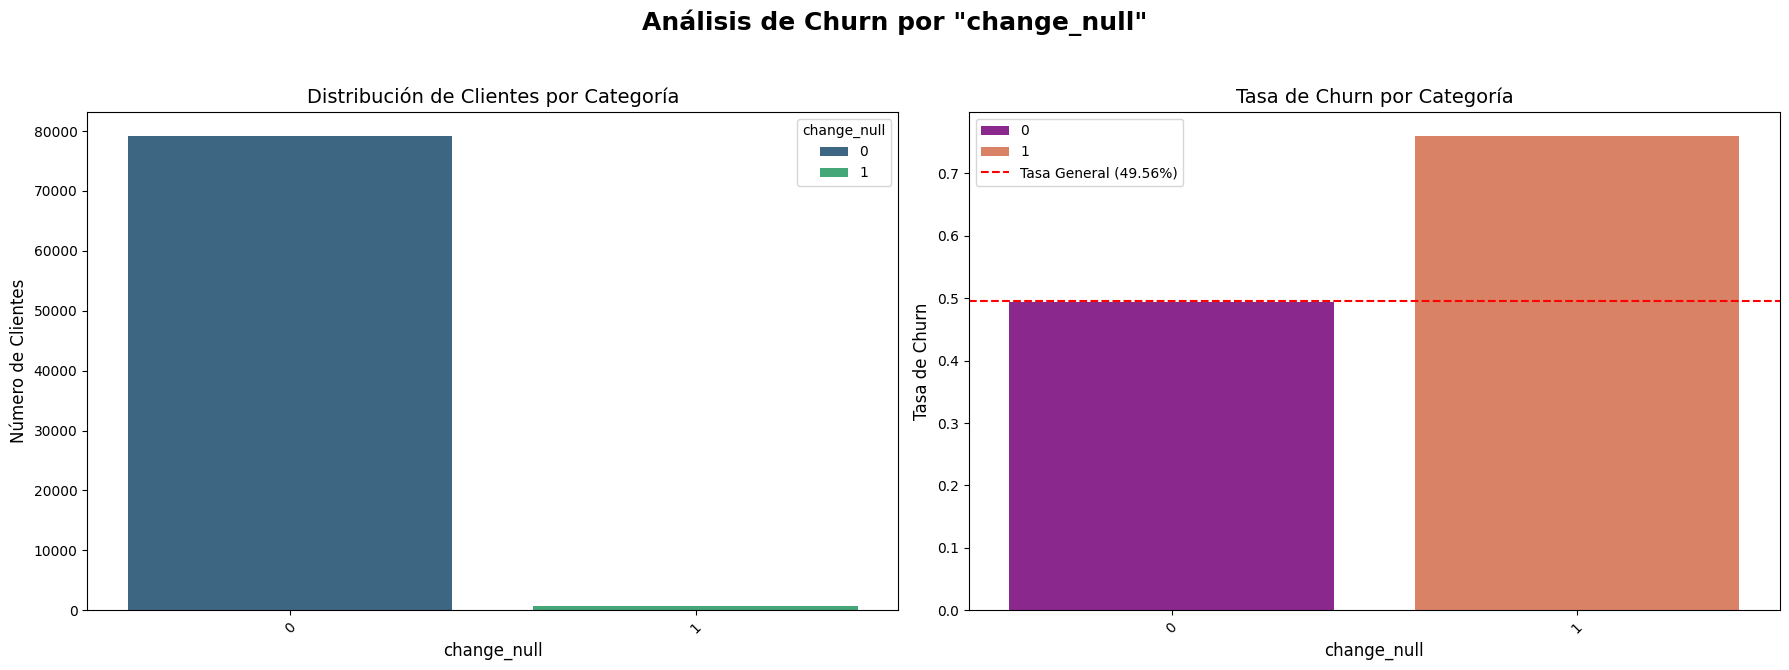

In [329]:
cols_Mean_null = ['change_mou', 'change_rev']

utils.crear_flag_nulos(df_limpio, 'change_mou', 'change_null')

utils.analizar_churn_categorica(df_limpio, 'change_null', target='churn')

En esta variable vemos que es el abandono de la gente que no tenía este apartado relleno es muy alto. Podría ser debido a la inactividad de los 3 meses anteriores, ya que si tenemos 0, la división por este número es indeterminado. Para ello, vamos a observar qué valor tienen las variables `avg3mou` y `avg3rev` para los casos en los que los campos `change_mou` y `change_rev` no existen.

In [330]:
df_change_nulos = df_limpio[df_limpio['change_mou'].isnull()].copy()

columnas_a_inspeccionar = ['avg3mou', 'avg3rev']

resumen_estadistico = df_change_nulos[columnas_a_inspeccionar].describe()
print(resumen_estadistico)
print(df_change_nulos[columnas_a_inspeccionar].head(10))

           avg3mou     avg3rev
count   718.000000  718.000000
mean    434.820334   56.552925
std     505.571295   57.580984
min       0.000000    1.000000
25%      84.000000   27.000000
50%     296.500000   41.000000
75%     577.000000   68.000000
max    5768.000000  849.000000
     avg3mou  avg3rev
86        24       20
155       91       31
254       23       38
271      209       33
390      202       35
431     1446      297
455      308       36
489      188       53
841      358       47
848      232       37


Esto nos deja ver que realmente sí que son usuarios activos, pero sin duda es producto de algo que deja desconforme a los usuarios. En estas variables de cambio, estaría también el revenue y los minutos de uso del mes actual, pero ese dato no lo tenemos. No sabemos sobre qué periodos están calculados `rev_Mean` y `mou_Mean`, así que esto seguramente venga de un problema más importante en la facturación del mes.

Vamos a inspeccionar la variable `eqpdays`, que se refiere a la novedad del teléfono actual.

In [331]:
# 'df_change_nulos' es el subconjunto donde change_mou es nulo
df_change_nulos = df_limpio[df_limpio['change_mou'].isnull()]

# 'df_change_ok' es el resto de la población
df_change_ok = df_limpio[df_limpio['change_mou'].notna()]

print("--- Resumen de Antigüedad del Teléfono ('eqpdays') ---")

print("\nPara el grupo con 'change' NULO (891 clientes):")
print(df_change_nulos['eqpdays'].describe())

print("\nPara el grupo NORMAL (el resto de clientes):")
print(df_change_ok['eqpdays'].describe())

--- Resumen de Antigüedad del Teléfono ('eqpdays') ---

Para el grupo con 'change' NULO (891 clientes):
count     718.000000
mean      535.665738
std       344.087781
min         3.000000
25%       294.000000
50%       467.500000
75%       773.000000
max      1813.000000
Name: eqpdays, dtype: float64

Para el grupo NORMAL (el resto de clientes):
count    79251.000000
mean       390.481874
std        255.823611
min         -5.000000
25%        211.000000
50%        341.000000
75%        528.000000
max       1823.000000
Name: eqpdays, dtype: float64


En general tienen equipos más antiguos que la media, eso igual podría implicar descontento y que se cambien de compañía por algún tipo de oferta en relación con su dispositivo.

In [332]:
tendencia_uso_3m_vs_6m_nulos = df_change_nulos['avg3mou'] - df_change_nulos['avg6mou']
tendencia_uso_3m_vs_6m_ok = df_change_ok['avg3mou'] - df_change_ok['avg6mou']

print(tendencia_uso_3m_vs_6m_nulos.describe())
print(tendencia_uso_3m_vs_6m_ok.describe())

tendencia_rev_3m_vs_6m_nulos = df_change_nulos['avg3rev'] - df_change_nulos['avg6rev']
tendencia_rev_3m_vs_6m_ok = df_change_ok['avg3rev'] - df_change_ok['avg6rev']

print(tendencia_rev_3m_vs_6m_nulos.describe())
print(tendencia_rev_3m_vs_6m_ok.describe())

count     657.000000
mean      -37.006088
std       168.659745
min     -1048.000000
25%       -79.000000
50%       -10.000000
75%        27.000000
max       747.000000
dtype: float64
count    77043.000000
mean         6.816284
std        145.705688
min      -2528.000000
25%        -37.000000
50%          2.000000
75%         51.000000
max       2284.000000
dtype: float64
count    657.000000
mean      -3.380518
std       22.905788
min     -142.000000
25%      -10.000000
50%       -2.000000
75%        2.000000
max      138.000000
dtype: float64
count    77043.000000
mean         0.435640
std         19.083293
min       -579.000000
25%         -3.000000
50%          0.000000
75%          3.000000
max        738.000000
dtype: float64


Con estos valores podemos ver que los usuarios cuyo cálculo es nulo, tienen un cambio drástico de uso en comparación con el resto de usuarios. En general, en los últimos 3 meses, la media de consumo ha bajado con respecto al resto de usuarios, pero aún no sabemos por qué.

/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(
/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


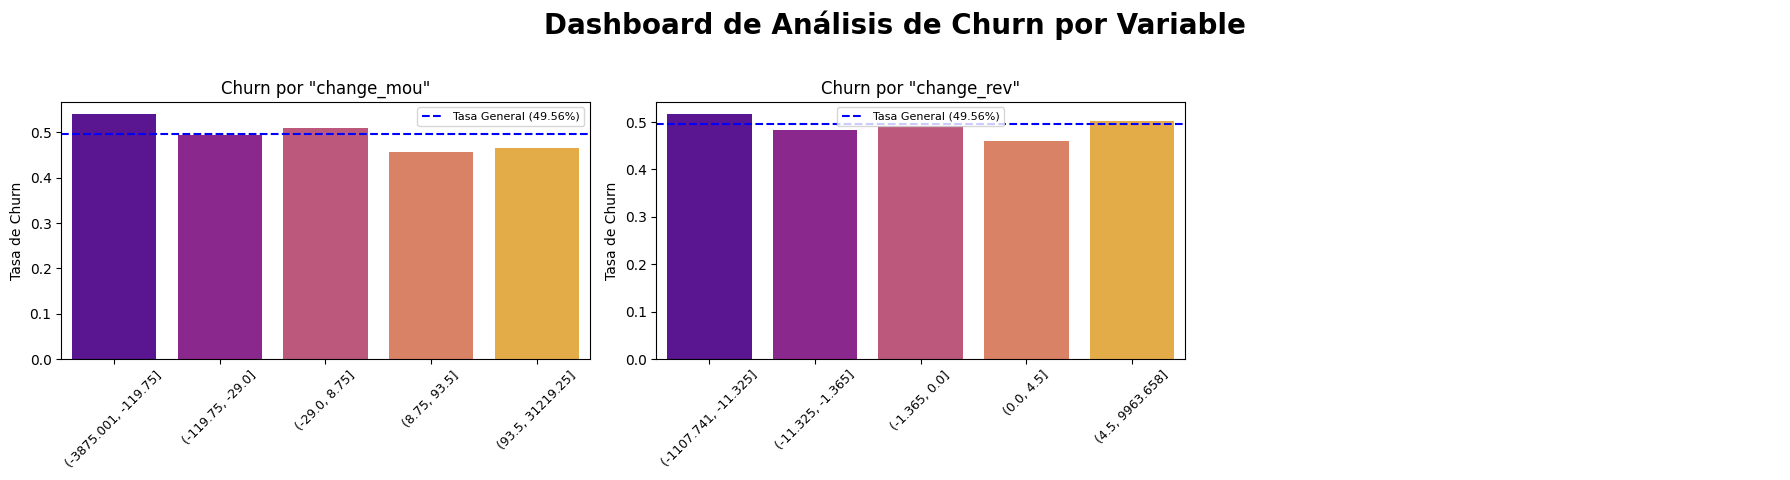

In [333]:
n_cols = len(['change_mou', 'change_rev'])

n_zayout_cols = 1  # Gráficos por fila (puedes cambiarlo a 2, 3, o 4)
n_layout_rows = (n_cols + n_layout_cols - 1) // n_layout_cols # Cálculo automático de filas

# 3. Crea la figura y los subplots
fig, axes = plt.subplots(n_layout_rows, n_layout_cols, figsize=(n_layout_cols * 6, n_layout_rows * 5))
fig.suptitle('Dashboard de Análisis de Churn por Variable', fontsize=20, weight='bold')

# 'axes' es una matriz de subplots, la aplanamos para iterar fácilmente
axes = axes.flatten()

for i, columna in enumerate(['change_mou', 'change_rev']):
    ax = axes[i]
    utils.plot_tasa_churn_numerica(df_limpio, columna, ax)

for i in range(n_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajustar para el título principal
plt.show()

Observamos que las personas cuyo uso ha aumentado mucho con respecto a los 3 meses anteriores (valores positivos [8,75-94.25] y [94.25-31219.25]) son personas con más lealtad y menos probabilidad de abandono. Sin embargo, la gente que ha disminuido su uso (con valores negativos de `change_mou`), tiene más probabilidad de abandonar, lo cual tiene sentido. Sin embargo, observamos que la gente cuyo pago ha aumentado mucho (valores muy positivos de `change_rev`), aumentan la probabilidad de abandono.

--- Análisis de Churn para la Variable Numérica: 'change_rev' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
                      Tasa de Churn  Total Clientes
change_rev_rango                                   
(-1107.741, -11.325]       0.516876           15851
(-11.325, -1.365]          0.482982           15866
(-1.365, 0.0]              0.490939           21852
(0.0, 4.5]                 0.461124            9839
(4.5, 9963.658]            0.502683           15843




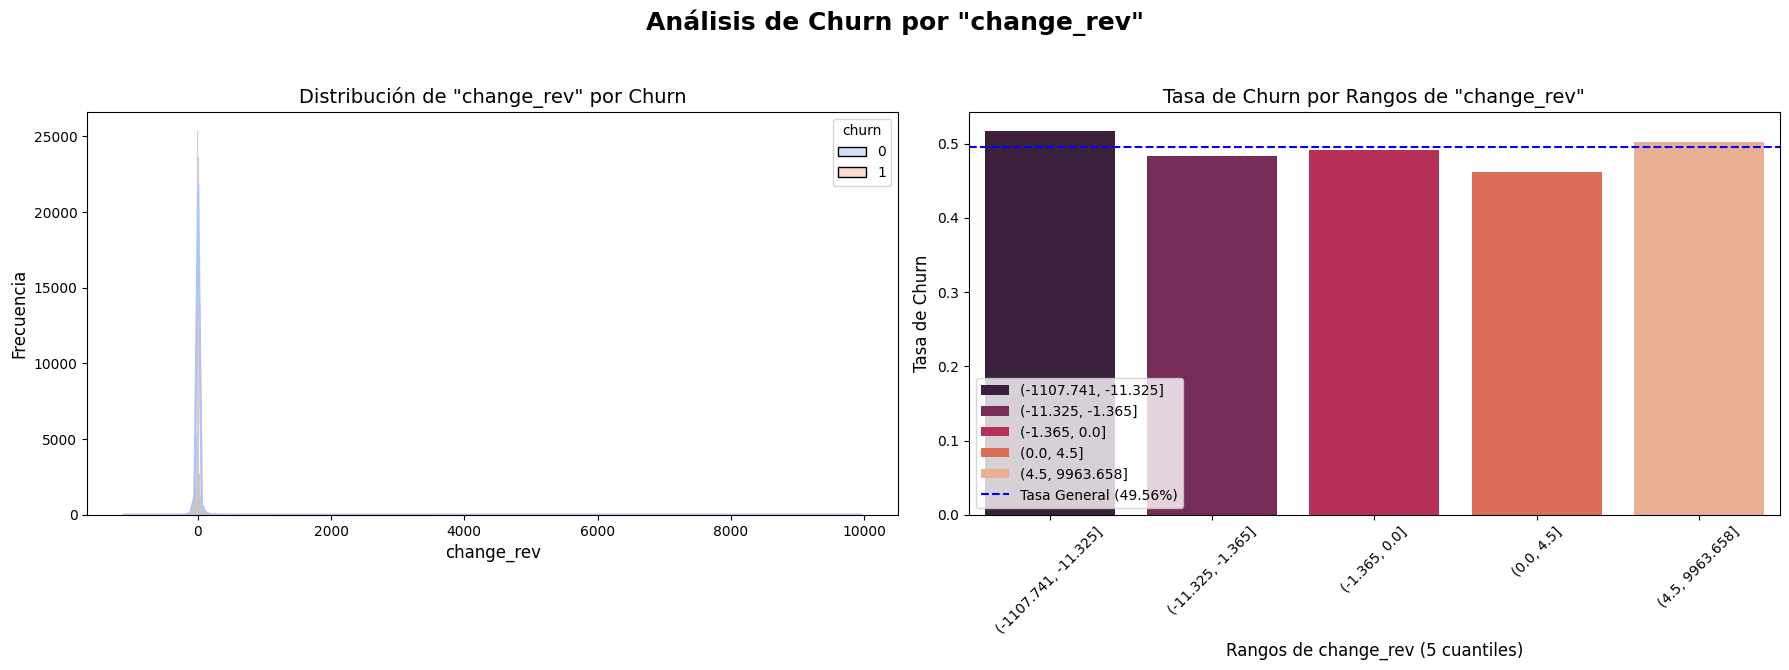

--- Análisis de Churn para la Variable Numérica: 'change_mou' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
                      Tasa de Churn  Total Clientes
change_mou_rango                                   
(-3875.001, -119.75]       0.540265           15870
(-119.75, -29.0]           0.494737           15865
(-29.0, 8.75]              0.508785           15879
(8.75, 93.5]               0.455679           15794
(93.5, 31219.25]           0.466200           15843




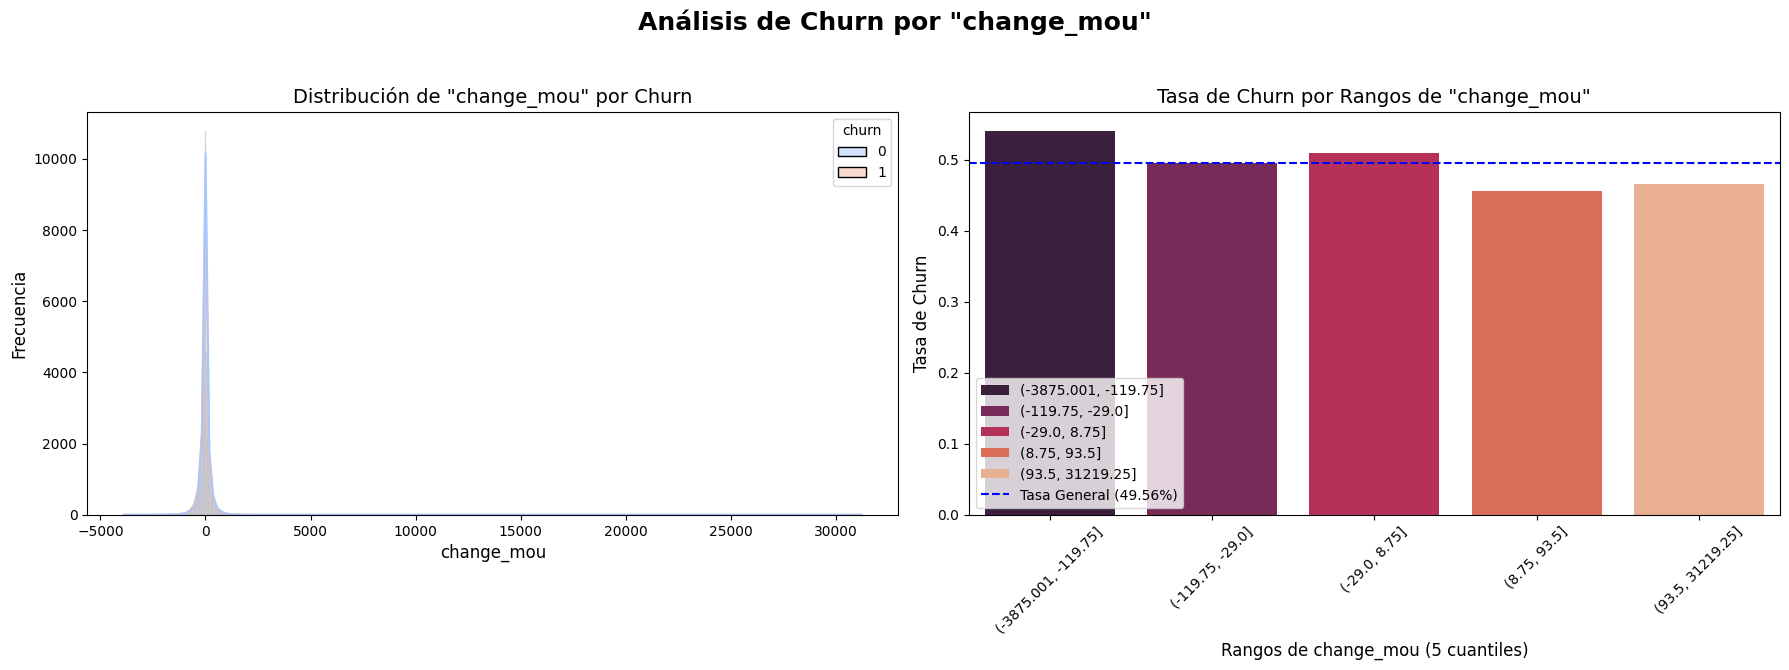

In [334]:
utils.analizar_churn_numerica(df_limpio, 'change_rev')
utils.analizar_churn_numerica(df_limpio, 'change_mou')

Observamos que una subida del uso también da lealtad, lo cual puede implicar servicios más de tarifa plana, cuyo aumento de uso no revierte en el cargo.

Tras este estudio, determinamos que imputamos estas variables por 0

In [335]:
df_limpio['change_mou'] = df_limpio['change_mou'].fillna(0)
df_limpio['change_rev'] = df_limpio['change_rev'].fillna(0)

null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
avg6mou            2269    2.837349
avg6qty            2269    2.837349
avg6rev            2269    2.837349
prizm_social_one   5896    7.372857
hnd_price           695    0.869087
hnd_webcap         8160   10.203954
ownrent           26990   33.750578
lor               24156   30.206705
dwlltype          25547   31.946129
adults            18441   23.060186
income            20362   25.462367
numbcars          39497   49.390389
HHstatin          30382   37.992222
dwllsize          30671   38.353612


### 4. Variable de media 6 meses

Número de 1s en la nueva columna flag: avg_null
1    2269
Name: count, dtype: int64

--- Análisis de Churn para la Variable Categórica: 'avg_null' ---
          Tasa de Churn  Total Clientes
avg_null                               
0              0.498366           77700
1              0.400176            2269




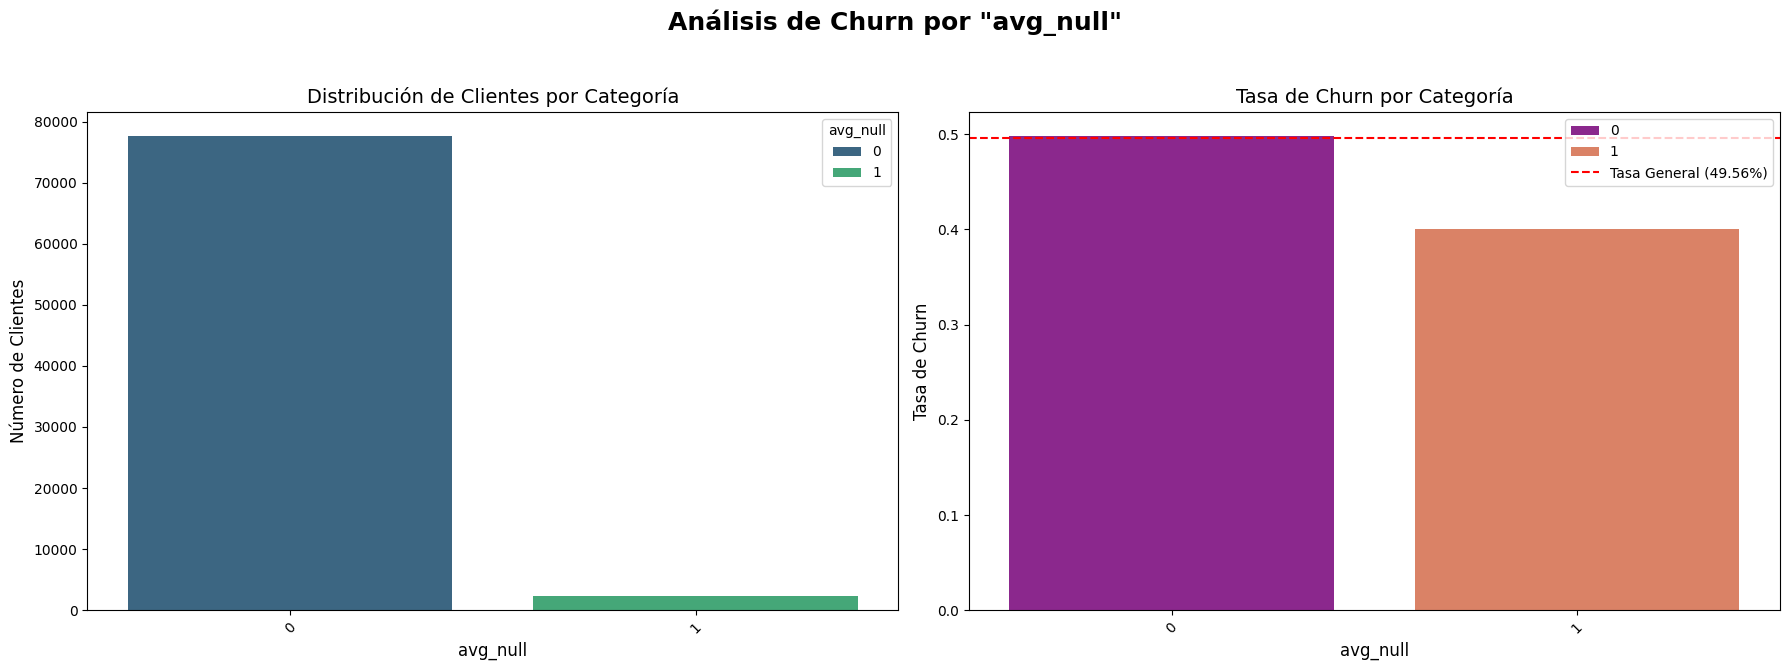

In [336]:
utils.crear_flag_nulos(df_limpio, 'avg6qty', 'avg_null')

utils.analizar_churn_categorica(df_limpio, 'avg_null')

Tener esta variable sin rellenar implica más fidelidad que el usuario medio. Vamos a ver cuánto tiempo llevan en la empresa estos usuarios.

In [337]:
df_avg_nulos = df_limpio[df_limpio['avg_null'] == 1]
df_avg_no_nulos = df_limpio[df_limpio['avg_null'] == 0]

print("--- Resumen de Antigüedad ('months') ---")

print("\nPara el grupo con 'avg' NULO (los supuestos 'legacy'):")
print(df_avg_nulos['months'].describe())

print("\nPara el grupo NORMAL:")
print(df_avg_no_nulos['months'].describe())

--- Resumen de Antigüedad ('months') ---

Para el grupo con 'avg' NULO (los supuestos 'legacy'):
count    2269.000000
mean        7.522257
std         4.610496
min         6.000000
25%         6.000000
50%         7.000000
75%         7.000000
max        60.000000
Name: months, dtype: float64

Para el grupo NORMAL:
count    77700.00000
mean        19.16130
std          9.57336
min          7.00000
25%         12.00000
50%         17.00000
75%         25.00000
max         61.00000
Name: months, dtype: float64


Hemos visto que los usuarios que no tienen este valor, tienen una media de permanencia en la empresa de 7 meses. Posiblemente, las variables `avg6` sólo se calculen sobre 6 meses más cerrados. Seguramente el máximo valor de 60 sea algún tipo de error. Por lo tanto, vamos a imputar este valor como 0 para estos nulos.

In [338]:
cols_avg6 = ['avg6qty', 'avg6rev', 'avg6mou']

df_limpio[cols_avg6] = df_limpio[cols_avg6].fillna(0)
print(df_limpio[cols_avg6].isnull().sum())

avg6qty    0
avg6rev    0
avg6mou    0
dtype: int64


### 5. Precio del handset

In [339]:
df_limpio['hnd_price'].describe()

count    79274.000000
mean       101.830190
std         61.017049
min          9.989998
25%         29.989990
50%         99.989990
75%        149.989990
max        499.989990
Name: hnd_price, dtype: float64

In [340]:
utils.crear_flag_nulos(df_limpio, 'hnd_price', 'hnd_price_null')


Número de 1s en la nueva columna flag: hnd_price_null
1    695
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,kid16_17,creditcd,eqpdays,Customer_ID,churn,infobase_null,services_null,change_null,avg_null,hnd_price_null
0,137.4925,784.00,50.0000,3.9600,272.50,81.7500,81.7500,0.0,1.7825,-704.00,...,U,Y,601.0,1039302,1,0,0,0,0,0
1,59.0650,1702.25,59.9900,0.0000,30.25,9.0750,9.0750,0.0,0.0000,264.75,...,U,N,156.0,1051213,0,1,0,0,0,0
2,44.4700,185.25,30.0000,2.9700,28.75,11.5000,11.5000,0.0,0.0000,-70.25,...,U,Y,1009.0,1006409,0,0,0,0,0,0
3,28.7450,10.75,39.9900,0.0000,0.00,0.0000,0.0000,0.0,0.0000,-3.75,...,U,Y,334.0,1057172,0,0,0,0,0,0
4,109.1925,1757.50,82.6925,0.0000,113.75,45.5000,45.5000,0.0,0.0000,84.50,...,U,N,223.0,1089300,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,150.2850,1867.50,87.4900,3.2175,270.00,67.5000,67.5000,0.0,0.5775,-781.50,...,U,N,249.0,1086168,0,1,0,0,0,0
79996,108.9300,1473.75,109.9900,4.7025,0.00,0.0000,0.0000,0.0,0.0000,463.25,...,U,Y,284.0,1035166,1,0,0,0,0,0
79997,142.4725,773.25,49.9900,1.4850,147.50,51.6250,51.6250,0.0,0.0000,127.75,...,U,N,63.0,1028247,0,1,0,0,0,0
79998,19.9900,14.00,19.9900,0.0000,0.00,0.0000,0.0000,0.0,0.0000,-14.00,...,U,Y,671.0,1032754,0,0,0,0,0,0


--- Análisis de Churn para la Variable Categórica: 'hnd_price_null' ---
                Tasa de Churn  Total Clientes
hnd_price_null                               
0                    0.496619           79274
1                    0.376978             695




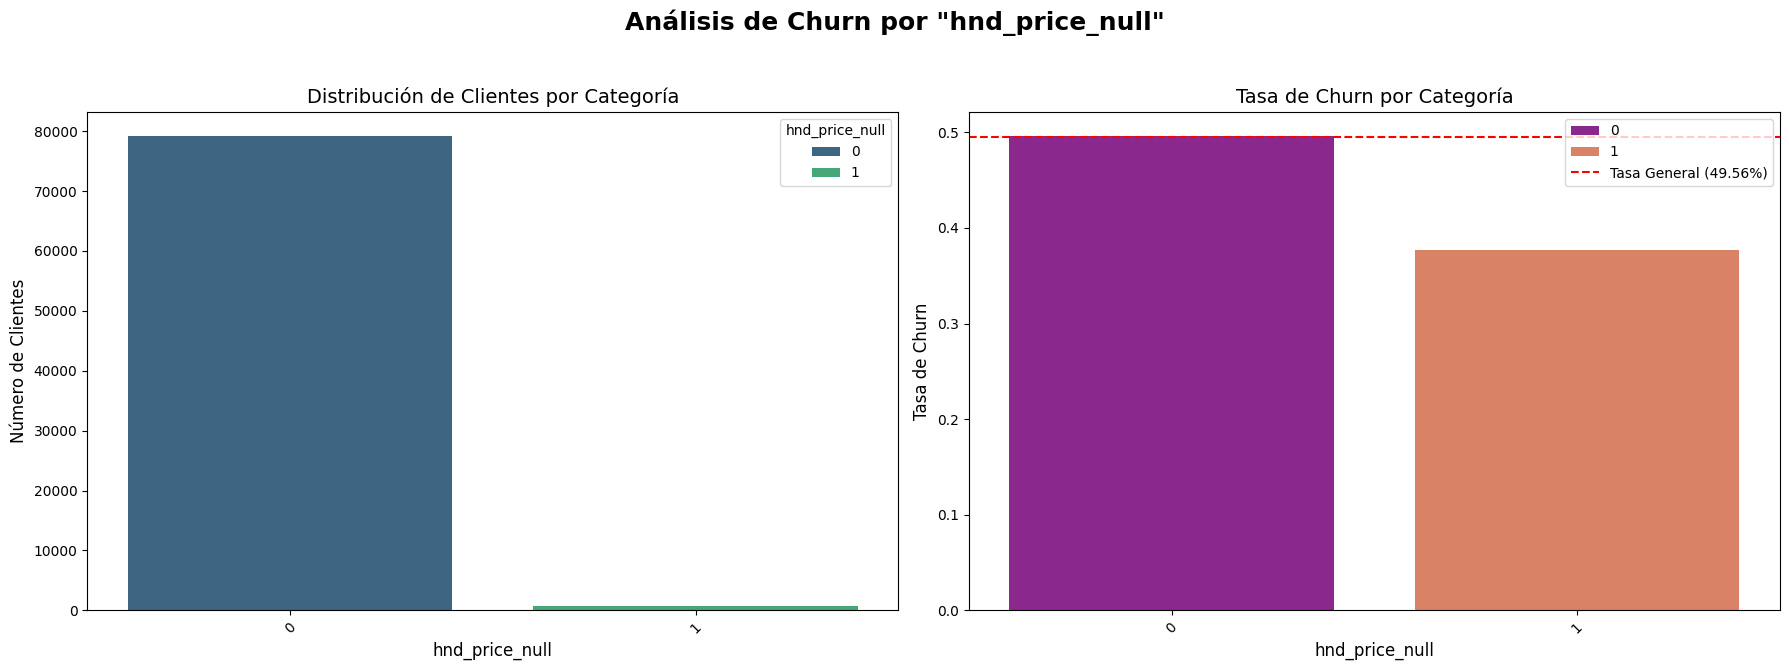

In [341]:
utils.analizar_churn_categorica(df_limpio, 'hnd_price_null')

De nuevo, tener el `hnd_price` vacío implica alta lealtad. Posiblemente puede ser porque hayan renovado el contrato para tener un nuevo dispositivo y no esté actualizado, o porque estén en un plan de empresa y el dispositivo no lo adquieran mediante esta compañía, si no por la suya.

Vamos a hacer una imputación por mediana.

In [342]:
valor_mediana = df_limpio['hnd_price'].median()
df_limpio['hnd_price'] = df_limpio['hnd_price'].fillna(valor_mediana)

### 6. Resto de nulos

In [343]:
null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
prizm_social_one   5896    7.372857
hnd_webcap         8160   10.203954
ownrent           26990   33.750578
lor               24156   30.206705
dwlltype          25547   31.946129
adults            18441   23.060186
income            20362   25.462367
numbcars          39497   49.390389
HHstatin          30382   37.992222
dwllsize          30671   38.353612


In [354]:
categoricas = ['prizm_social_one', 'hnd_webcap', 'ownrent', 
    'dwlltype', 'HHstatin', 'dwllsize']

# Añadimos otra categoría llamada UNKN

for col in categoricas:
    if col in df_limpio.columns:
        utils.crear_flag_nulos(df_limpio, col, f'{col}_null')
            
        df_limpio[col] = df_limpio[col].fillna('UNKN')

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)



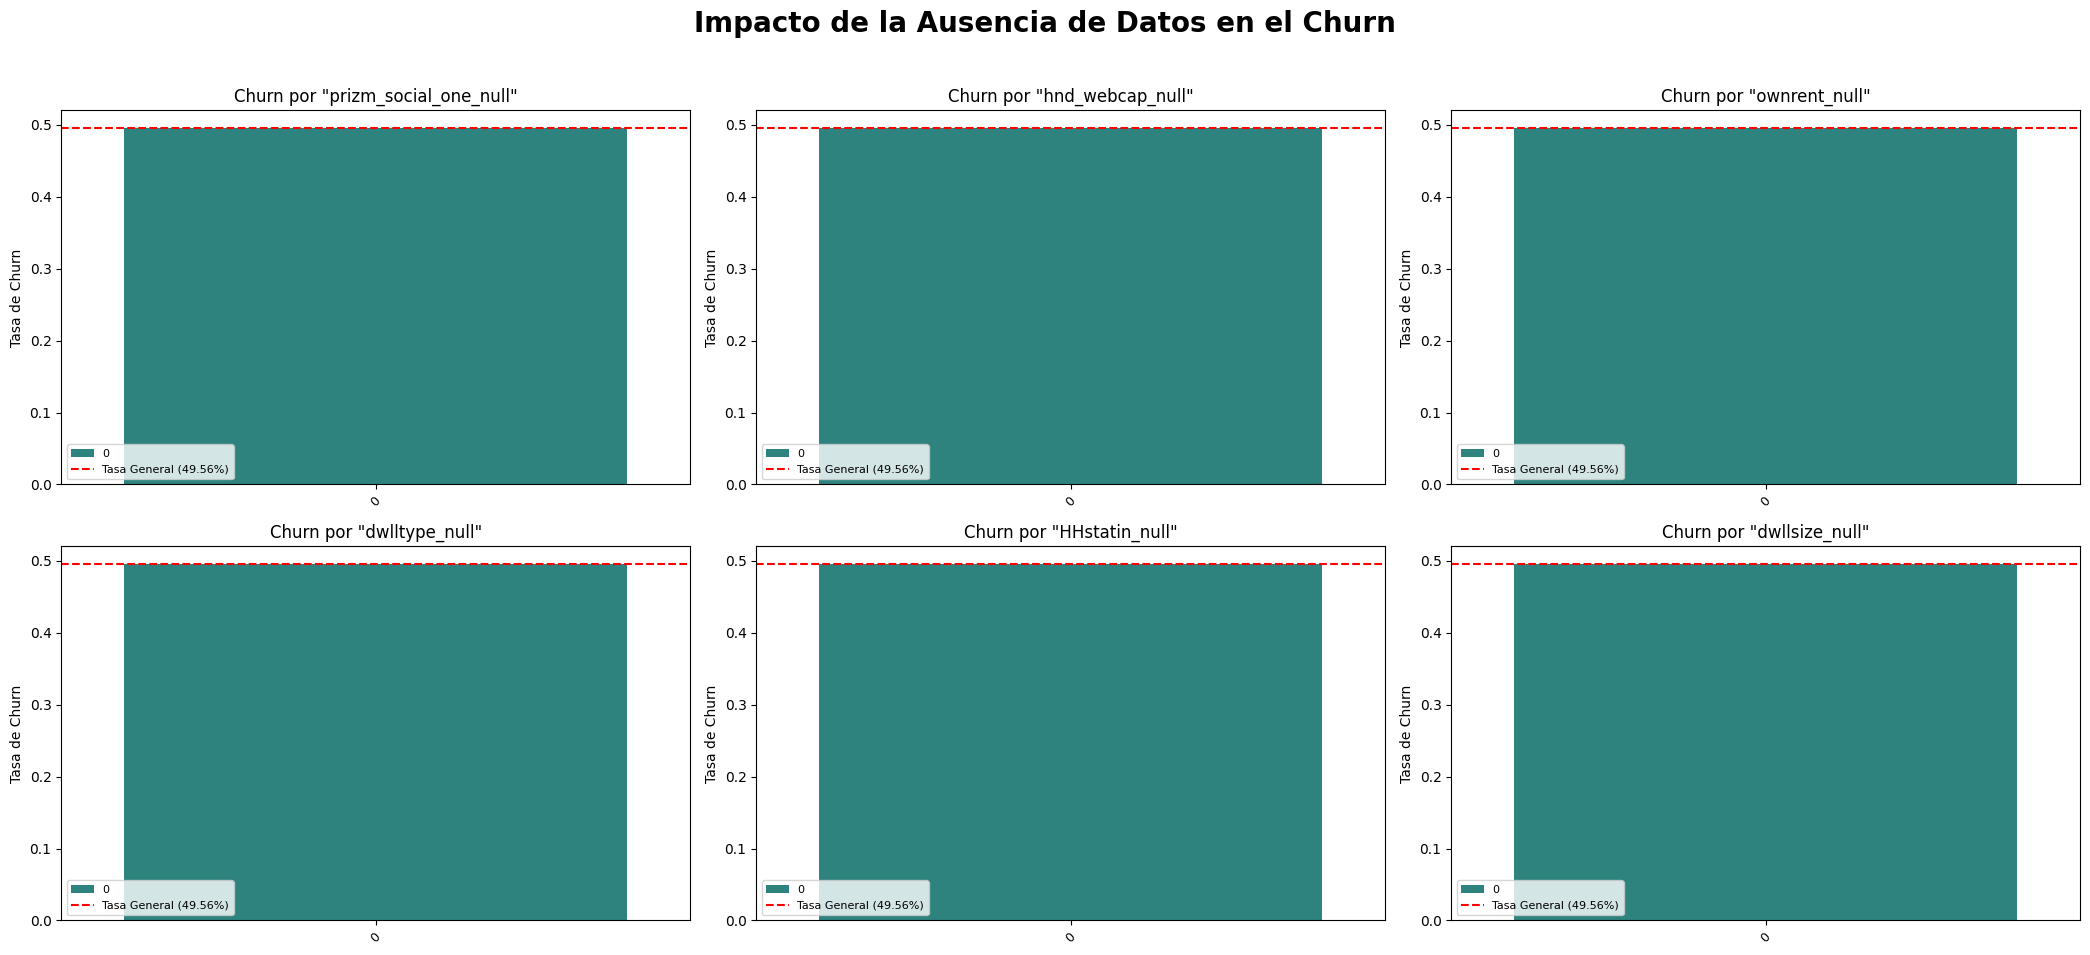

In [355]:
#flag_cols = [col for col in df_limpio.columns if col.endswith('_null')]

flag_cols = ['prizm_social_one_null', 'hnd_webcap_null', 'ownrent_null', 
    'dwlltype_null', 'HHstatin_null', 'dwllsize_null']


n_flags = len(flag_cols)
n_layout_cols = 3  # Gráficos por fila (puedes cambiarlo)
n_layout_rows = (n_flags + n_layout_cols - 1) // n_layout_cols

fig, axes = plt.subplots(n_layout_rows, n_layout_cols, figsize=(n_layout_cols * 7, n_layout_rows * 5))
fig.suptitle('Impacto de la Ausencia de Datos en el Churn', fontsize=20, weight='bold')

axes = axes.flatten()

for i, columna_flag in enumerate(flag_cols):
    ax = axes[i]
    # Llamamos a la función de graficado para cada flag
    utils.plot_tasa_churn_categorica(df_limpio, columna_flag, ax)

for i in range(n_flags, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

No tener alguna de estas características aumenta la tasa de abandono por encima de la media. Si nos fijamos, muchas de ellas se refieren a datos demográficos (si tienen o alquilan casa, categoría de la casa, categoría social...). No dar estos datos es un síntoma quizá de desinterés, en el caso de `hnd_webcap_null` posiblemente se desconoce por el tipo de dispositivo, que quizá esté obsoleto, etc.

In [356]:
null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

Empty DataFrame
Columns: [Nulos, Porcentaje]
Index: []


Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)



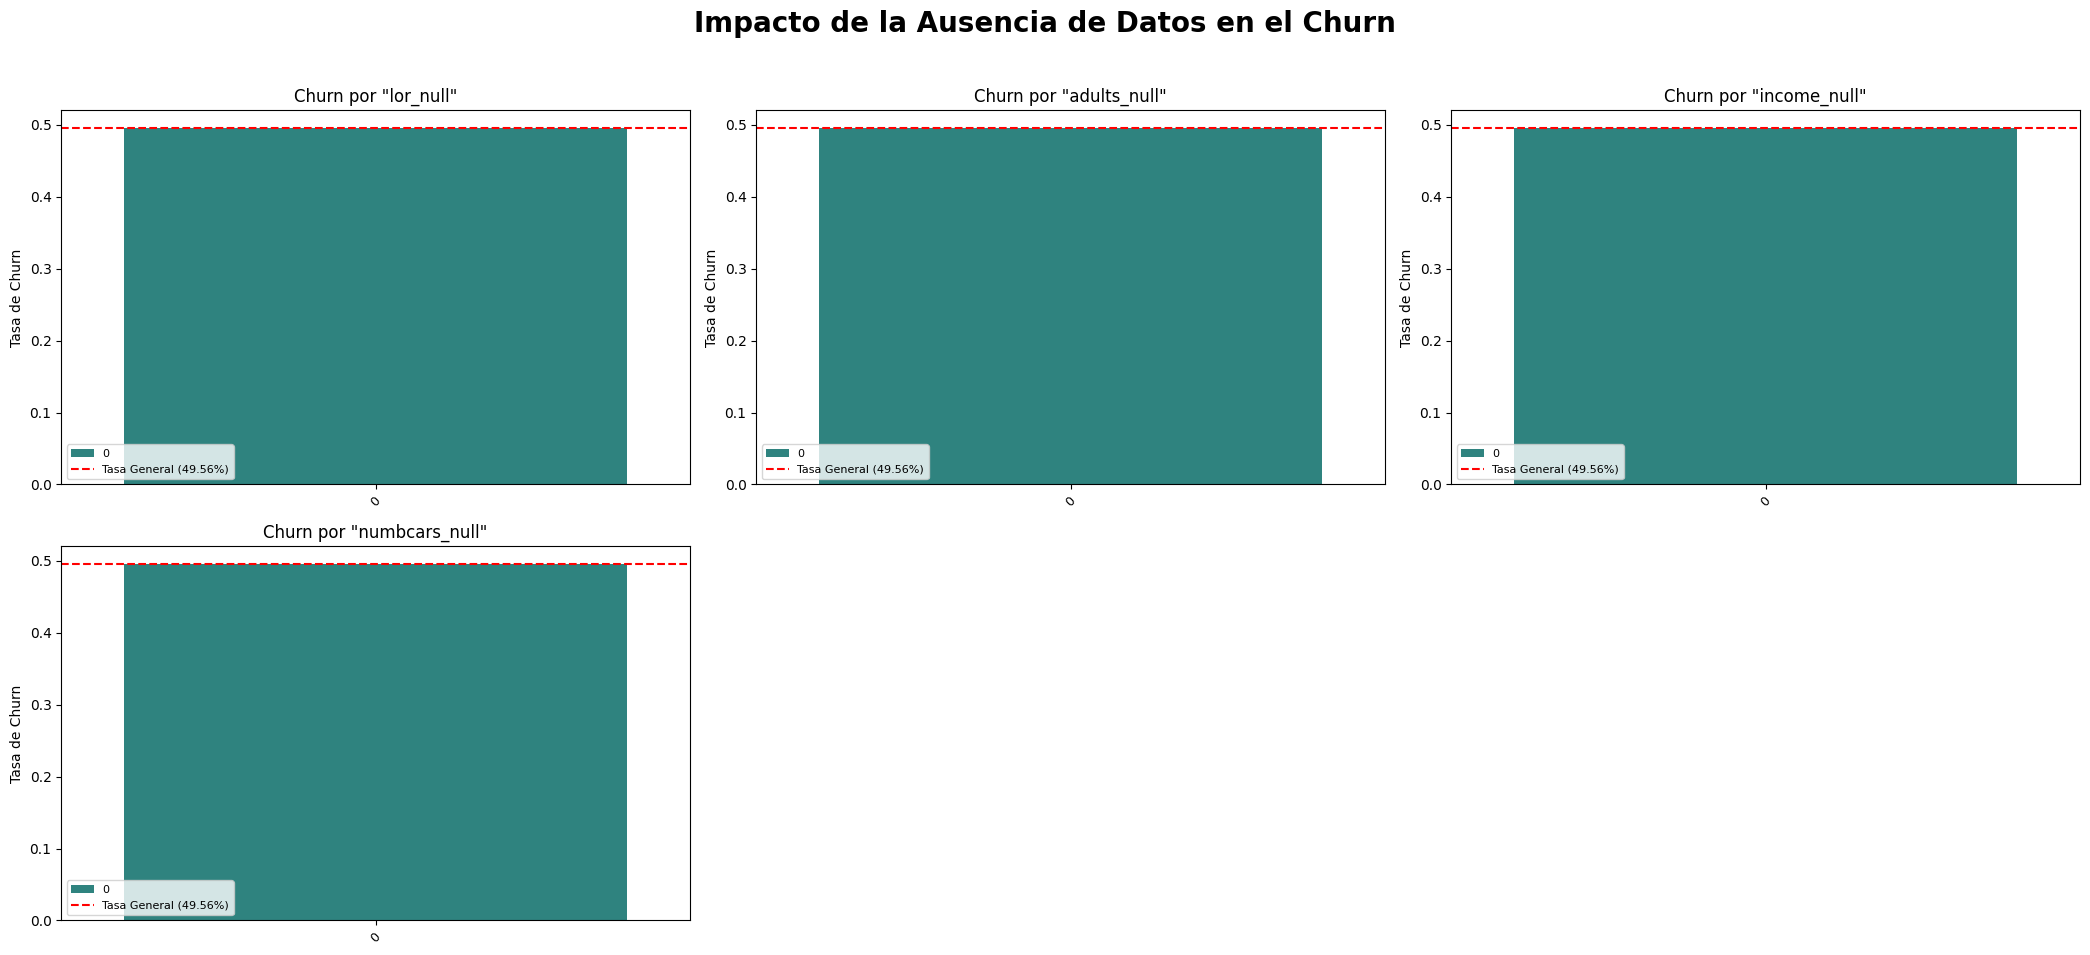

In [357]:
nulos_numericos = ['lor', 'adults', 'income', 'numbcars']

for col in nulos_numericos:
    utils.crear_flag_nulos(df_limpio, col, f'{col}_null')

flag_cols = ['lor_null', 'adults_null', 'income_null', 'numbcars_null']
n_flags = len(flag_cols)
n_layout_cols = 3  # Gráficos por fila (puedes cambiarlo)
n_layout_rows = (n_flags + n_layout_cols - 1) // n_layout_cols

fig, axes = plt.subplots(n_layout_rows, n_layout_cols, figsize=(n_layout_cols * 7, n_layout_rows * 5))
fig.suptitle('Impacto de la Ausencia de Datos en el Churn', fontsize=20, weight='bold')

axes = axes.flatten()

for i, columna_flag in enumerate(flag_cols):
    ax = axes[i]
    # Llamamos a la función de graficado para cada flag
    utils.plot_tasa_churn_categorica(df_limpio, columna_flag, ax)

for i in range(n_flags, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

--- Análisis de Churn para la Variable Numérica: 'lor' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
               Tasa de Churn  Total Clientes
lor_rango                                   
(-0.001, 2.0]       0.518137           17009
(2.0, 5.0]          0.505118           37122
(5.0, 8.0]          0.471624            9885
(8.0, 15.0]         0.464176           15953




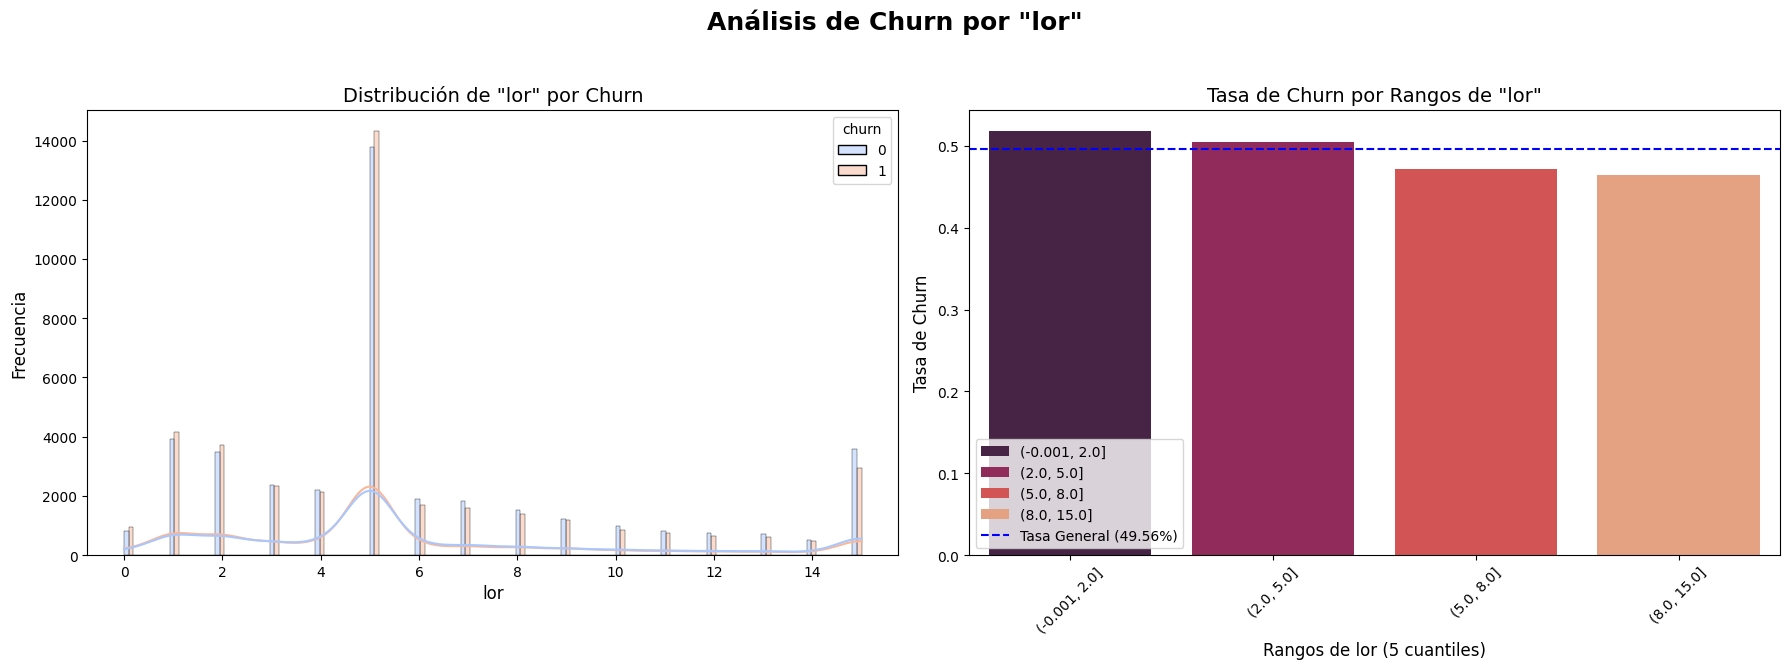

--- Análisis de Churn para la Variable Numérica: 'adults' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
              Tasa de Churn  Total Clientes
adults_rango                               
(0.999, 2.0]       0.501402           54573
(2.0, 3.0]         0.485229           11001
(3.0, 6.0]         0.481417           14395




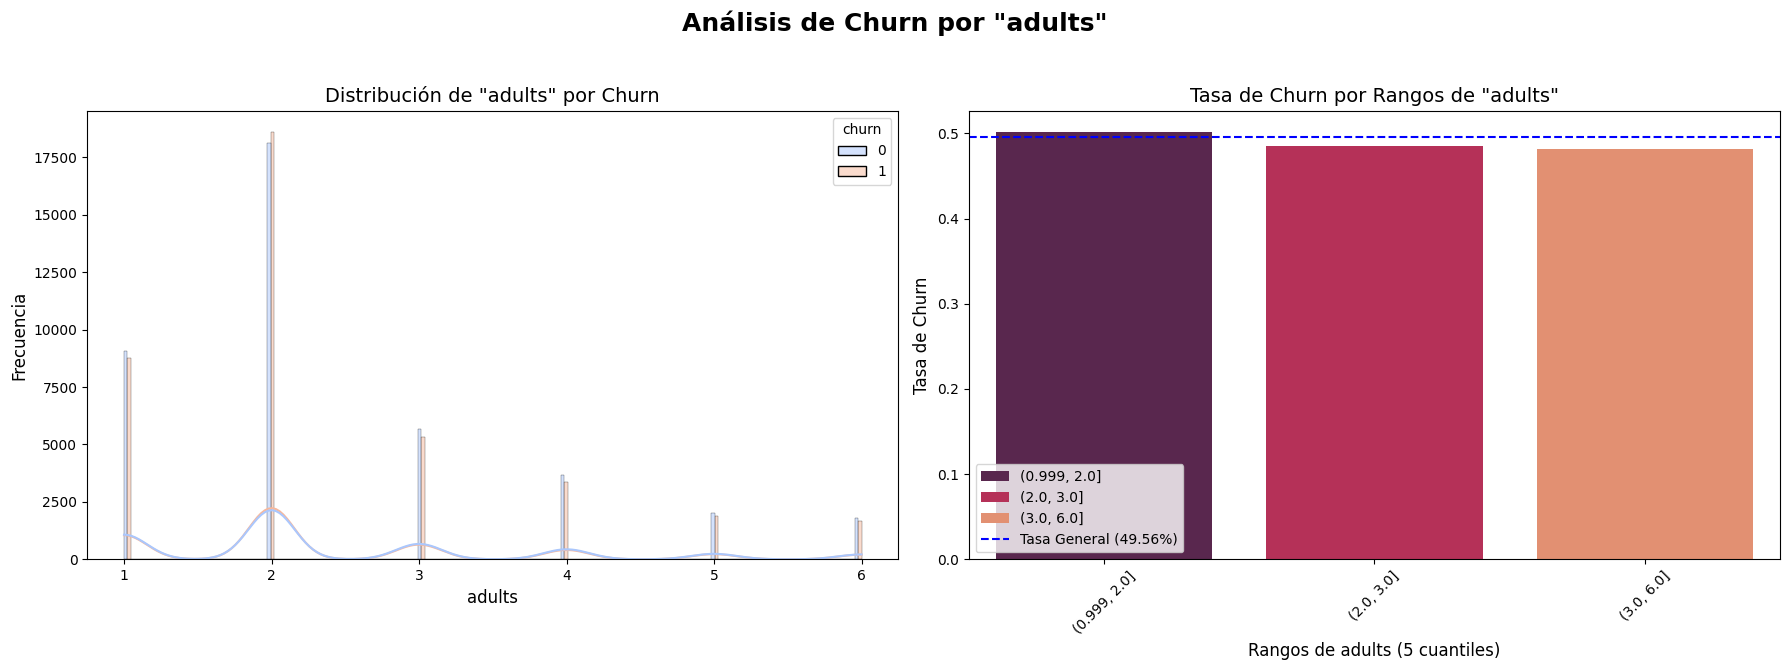

--- Análisis de Churn para la Variable Numérica: 'income' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
              Tasa de Churn  Total Clientes
income_rango                               
(0.999, 5.0]       0.482061           22576
(5.0, 6.0]         0.504999           35307
(6.0, 7.0]         0.506841            9356
(7.0, 9.0]         0.485153           12730




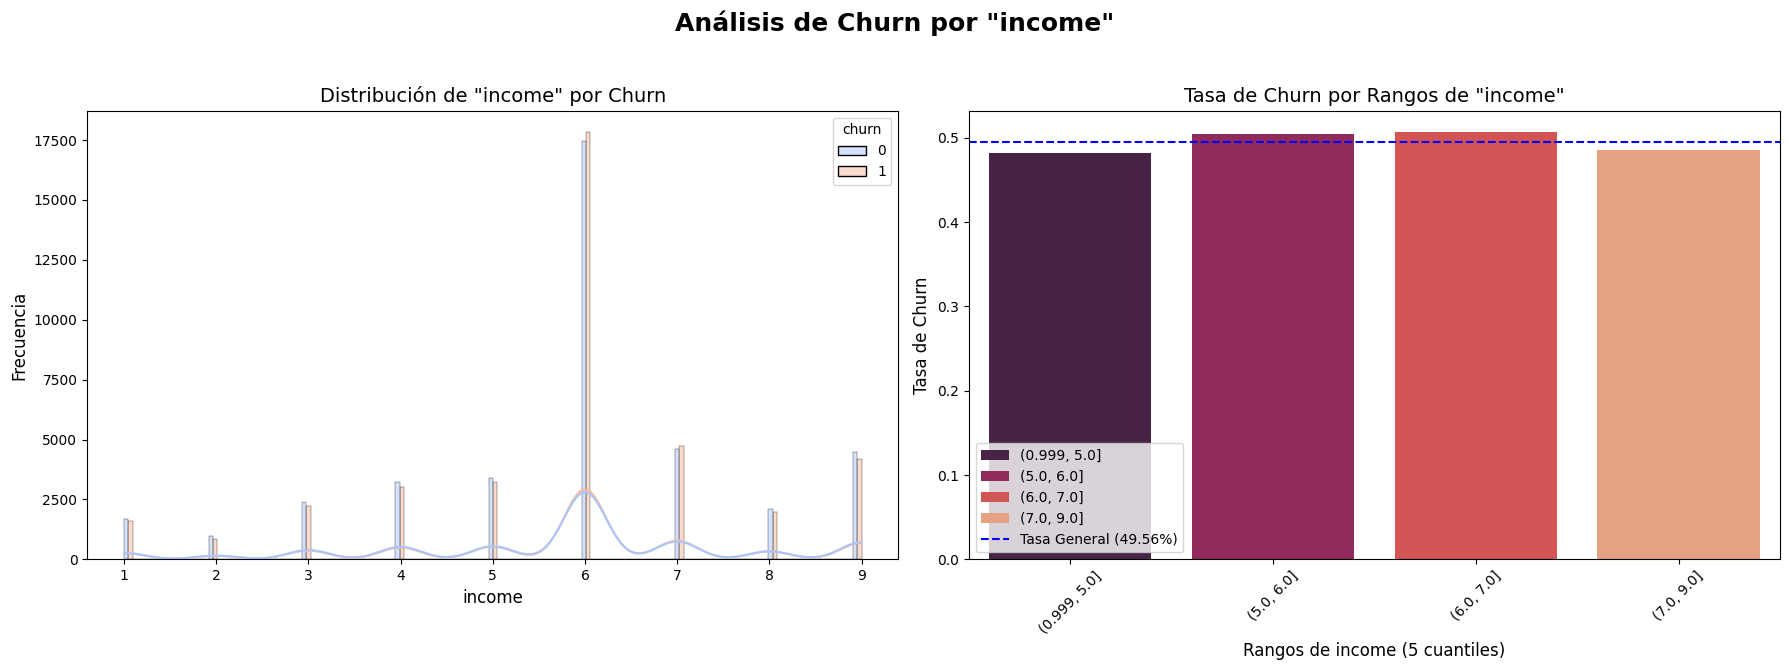

--- Análisis de Churn para la Variable Numérica: 'numbcars' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
                Tasa de Churn  Total Clientes
numbcars_rango                               
(0.999, 2.0]         0.496507           77004
(2.0, 3.0]           0.471501            2965




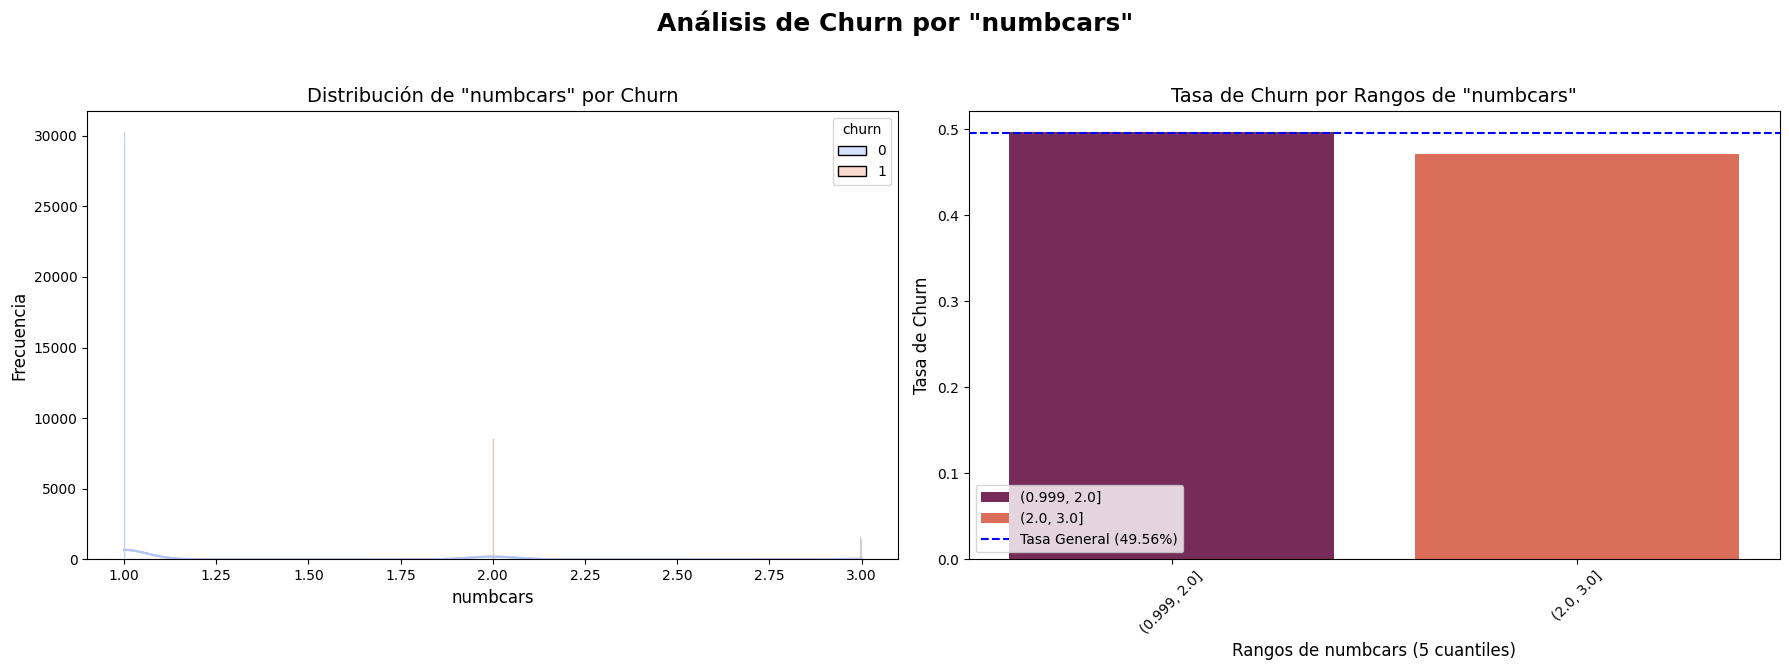

In [358]:
for columna in nulos_numericos:
    # La llamada a la función es simple, sin pasarle ningún 'ax'
    utils.analizar_churn_numerica(df_limpio, columna)


Dado que sólo estamos actuando en base a los usuarios que tienen estos datos rellenados, la muestra de información es más pequeña. De todos modos, por lo que vemos, no son demasiado predictivas. En `lor` e `income` vemos una distribución más o menos normal de los usuarios, pero con casos extremos, por lo tanto imputamos con mediana. Lo mismo haremos con `numbcars` y `adults`, donde el peso está en una zona concreta del gráfico.

In [359]:
for col in nulos_numericos:
    mediana = df_limpio[col].median()
    df_limpio[col] = df_limpio[col].fillna(mediana)

null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

Empty DataFrame
Columns: [Nulos, Porcentaje]
Index: []
